# How might a dating app decide who to match?

### Dating apps sell people on finding love, and different apps run differently depending on what they are trying to advertise.

#### 1. One app might advertise that it will send you your dream match.  In this case members see many others they might be interested in, but the interest may not be reciprocal.  This business model may keep clients on the app longer in hopes of their dream match finally accepting them, even though the other member may not reciprocate as often as they would like.

#### 2.  One app might advertise it produces high quality matches, where both members enjoy high levels of compatibility.  While the level of 'dreaminess' may not be as high as the first app, it can advertise more reciprocation.

In this project we will analyze speed dating data to determine which factors are most important when a person decides whether to accept a match or not.  Then we will use these important features to determine which algorithm would make the best suggestions, depending on whether we are using dating app model 1 or 2.

The <a href="http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/">data</a> we use was compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar for their paper<a href= "https://www0.gsb.columbia.edu/mygsb/faculty/research/pubfiles/867/datingFULL-EK1.pdf#:~:text=We%20study%20dating%20behavior%20using%20data%20from%20a,while%20femaleselectivity%20is%20strongly%20increasing%20in%20group%20size"> Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment. </a>  They collected data from 21 speed dating events to analyze their decisions.

### Table of Contents
1. [Understanding and cleaning the data](#data)
2. [Analysis of the data using Random Forest](#analysis)
3. [The matching algorithms](#algorithms)
4. [Optimizing for women only](#women_only)
5. [Optimizing for a mutual match](#mutual)
6. [Concluding remarks](#conclusion)

## Understanding and cleaning the data <a id="data"></a>

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score

In [77]:
dff=pd.read_csv('../Python Dating/Speed Dating Data.csv')

In [3]:
dff.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


We can find the meanings of all of these column headers <a href="http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/">here</a>.  What we will be focusing on is the following: Each night of speed dating is called a 'wave.' Each row in the dataset consists of matching 2 people of opposite genders in a wave.  They rate each other based on several main categories, in particular attraction, ambition, intellegence, shared interests, sincerity, level of fun, and overall how much they liked them. Participants are also asked how important these aspects are when choosing a partner, labelled by a pair of numbers. (E.g. attr1_1 is how important attraction to a person.)  They give their decisions (0 is no, 1 is yes), and there is a match if both say yes.

We begin by observing and cleaning the missing data

In [49]:
def percent_missing(df,percent=0):
    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>percent].sort_values()
    return percent_nan

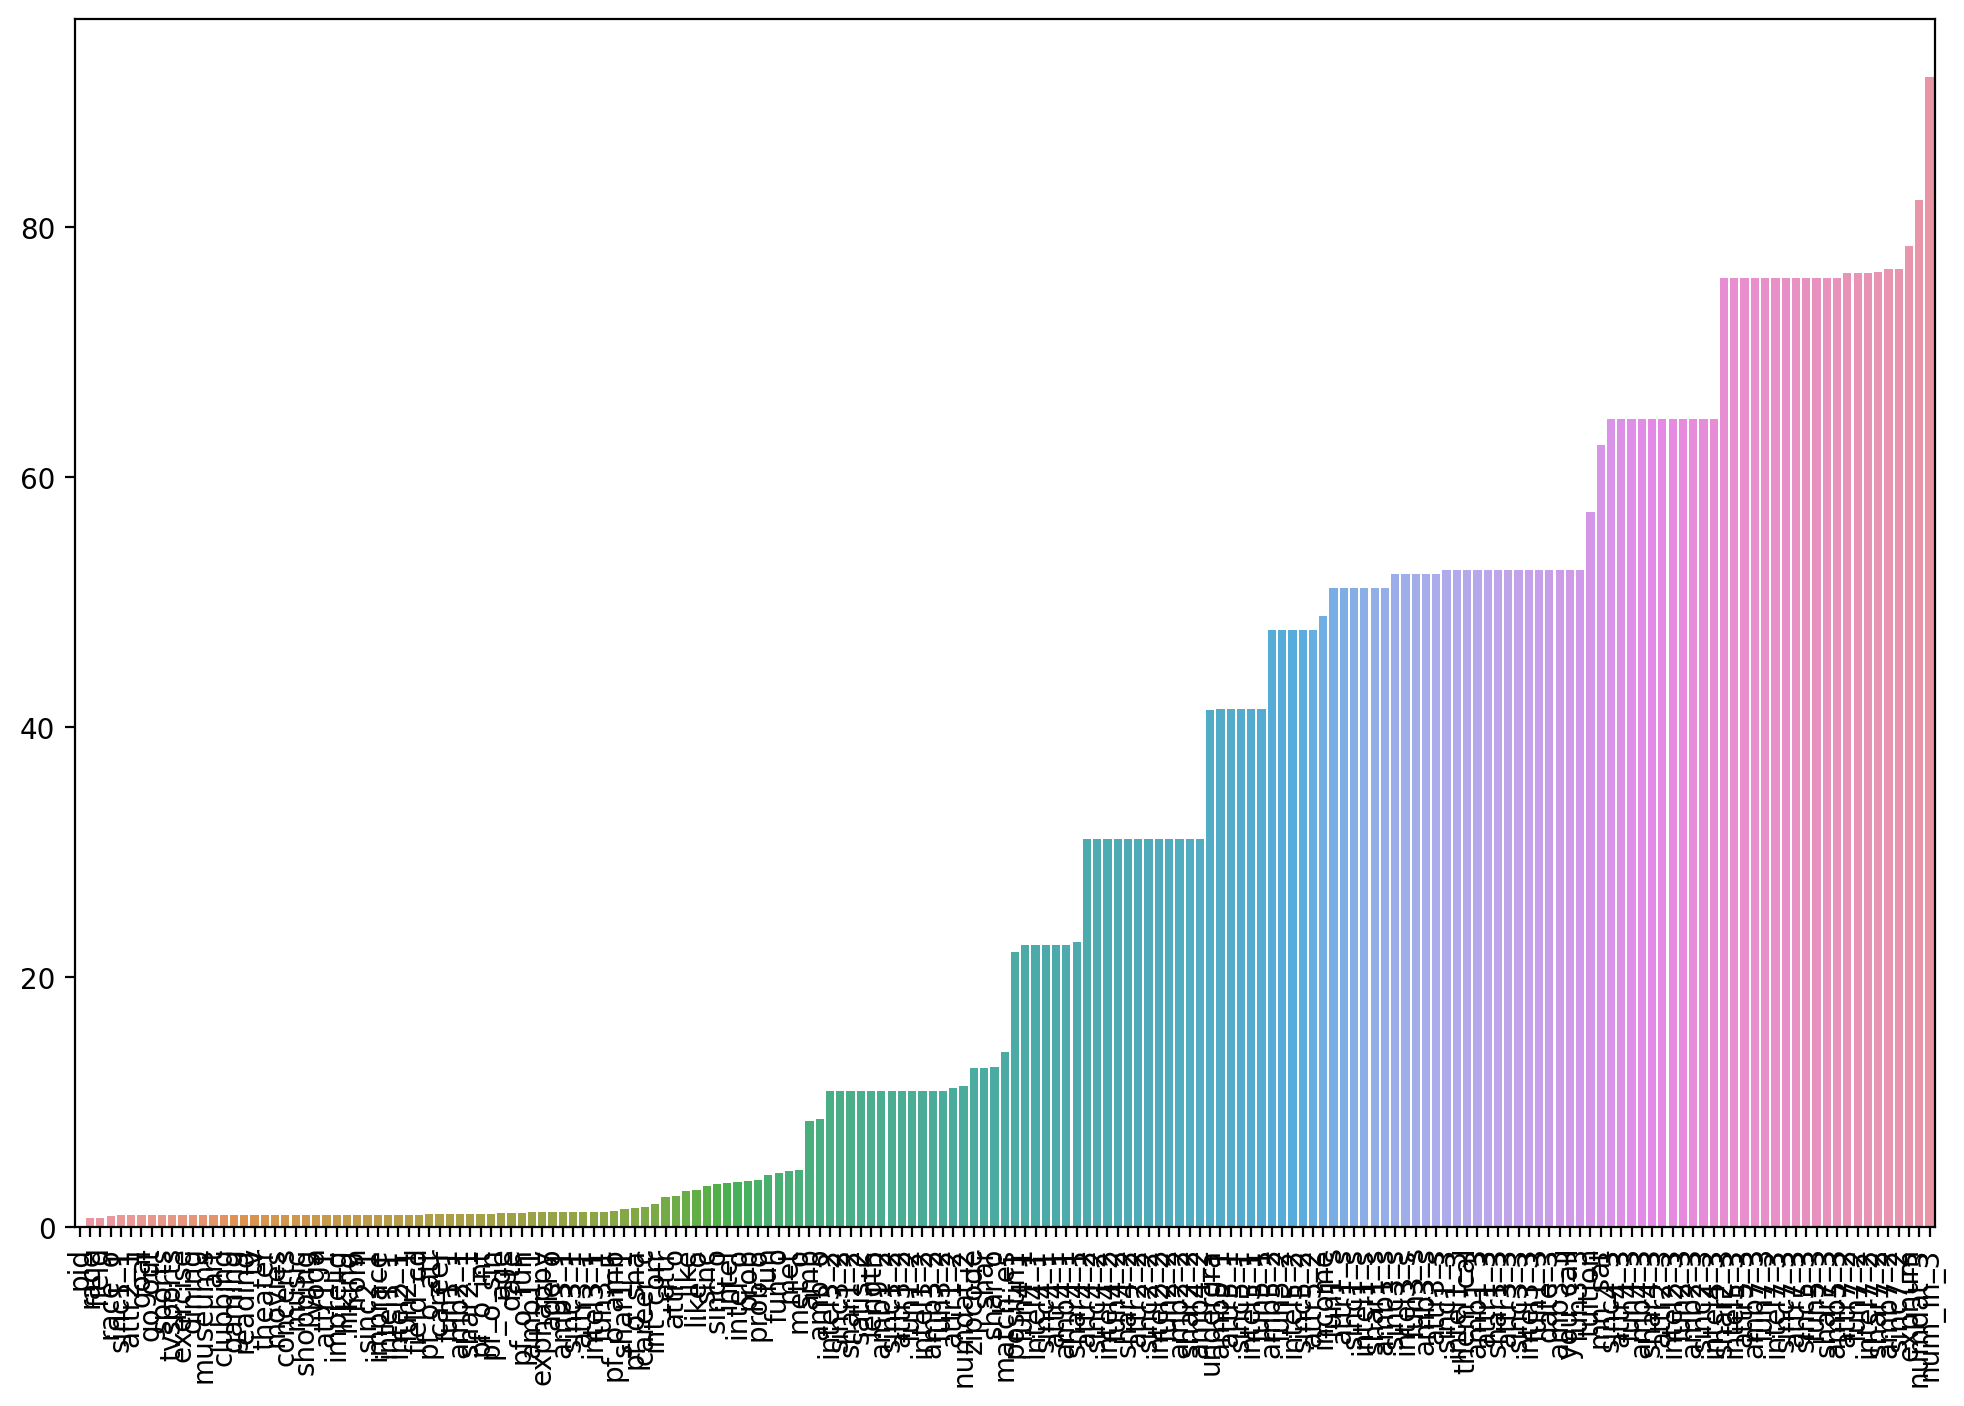

In [5]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff).index,y=percent_missing(dff))
plt.xticks(rotation=90);

There appears to be a lot of missing data overall.  Though there may be some data that was tracked better in some waves than in others. So let us see if among these columns, if there are any waves with at least 75% of the data remaining:

In [6]:
popular={}
for cat in  list(percent_missing(dff,50).keys()):   
    waves=[]
    for i in range(1,22):
         if cat not in percent_missing(dff[dff['wave']==i],25):
                waves.append(i)
    l=len(waves)
    popular[cat]=waves,l
popular

{'shar1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'attr1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'sinc1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'intel1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'fun1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'amb1_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'amb3_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'intel3_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'sinc3_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'fun3_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'attr3_s': ([6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20], 12),
 'fun1_3': ([8, 10], 2),
 'date_3': ([8, 10], 2),
 'them_cal': ([8, 10], 2),
 'intel1_3': ([8, 10], 2),
 'you_call': ([8, 10], 2),
 'shar1_3': ([8, 10], 2),
 'amb1_3': ([8, 10], 2),
 'sinc3_3': ([8, 10], 2),
 'intel3_3': ([8, 10], 2),
 'fun3_3': ([8, 10], 2),
 'sinc1_3': ([8, 10], 2),
 'amb3_3': (

It looks like aside from the 1_s,3_s, SAT columns, the rest are not that common in each of them.  So let us drop these from the dataset. 

In [78]:
#Among categories with overall 50% missing data, only the 1_s and 3_s categories are 75% present in most of the waves.
#So we will drop the other categories.
dff1=dff.drop(['fun1_3', 'date_3', 'them_cal', 'intel1_3', 'you_call', 'shar1_3', 'amb1_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'sinc1_3', 'amb3_3', 'attr3_3', 'attr1_3', 'tuition', 'mn_sat', 'shar4_3', 'amb2_3', 'fun2_3', 'intel2_3', 'sinc2_3', 'attr2_3', 'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'intel5_3', 'sinc5_3', 'attr5_3', 'shar2_3', 'amb5_3', 'shar7_3', 'amb7_3', 'fun7_3', 'intel7_3', 'sinc7_3', 'attr7_3', 'fun5_3', 'fun7_2', 'intel7_2', 'attr7_2', 'shar7_2', 'sinc7_2', 'amb7_2', 'expnum', 'numdat_3', 'num_in_3'],axis=1)

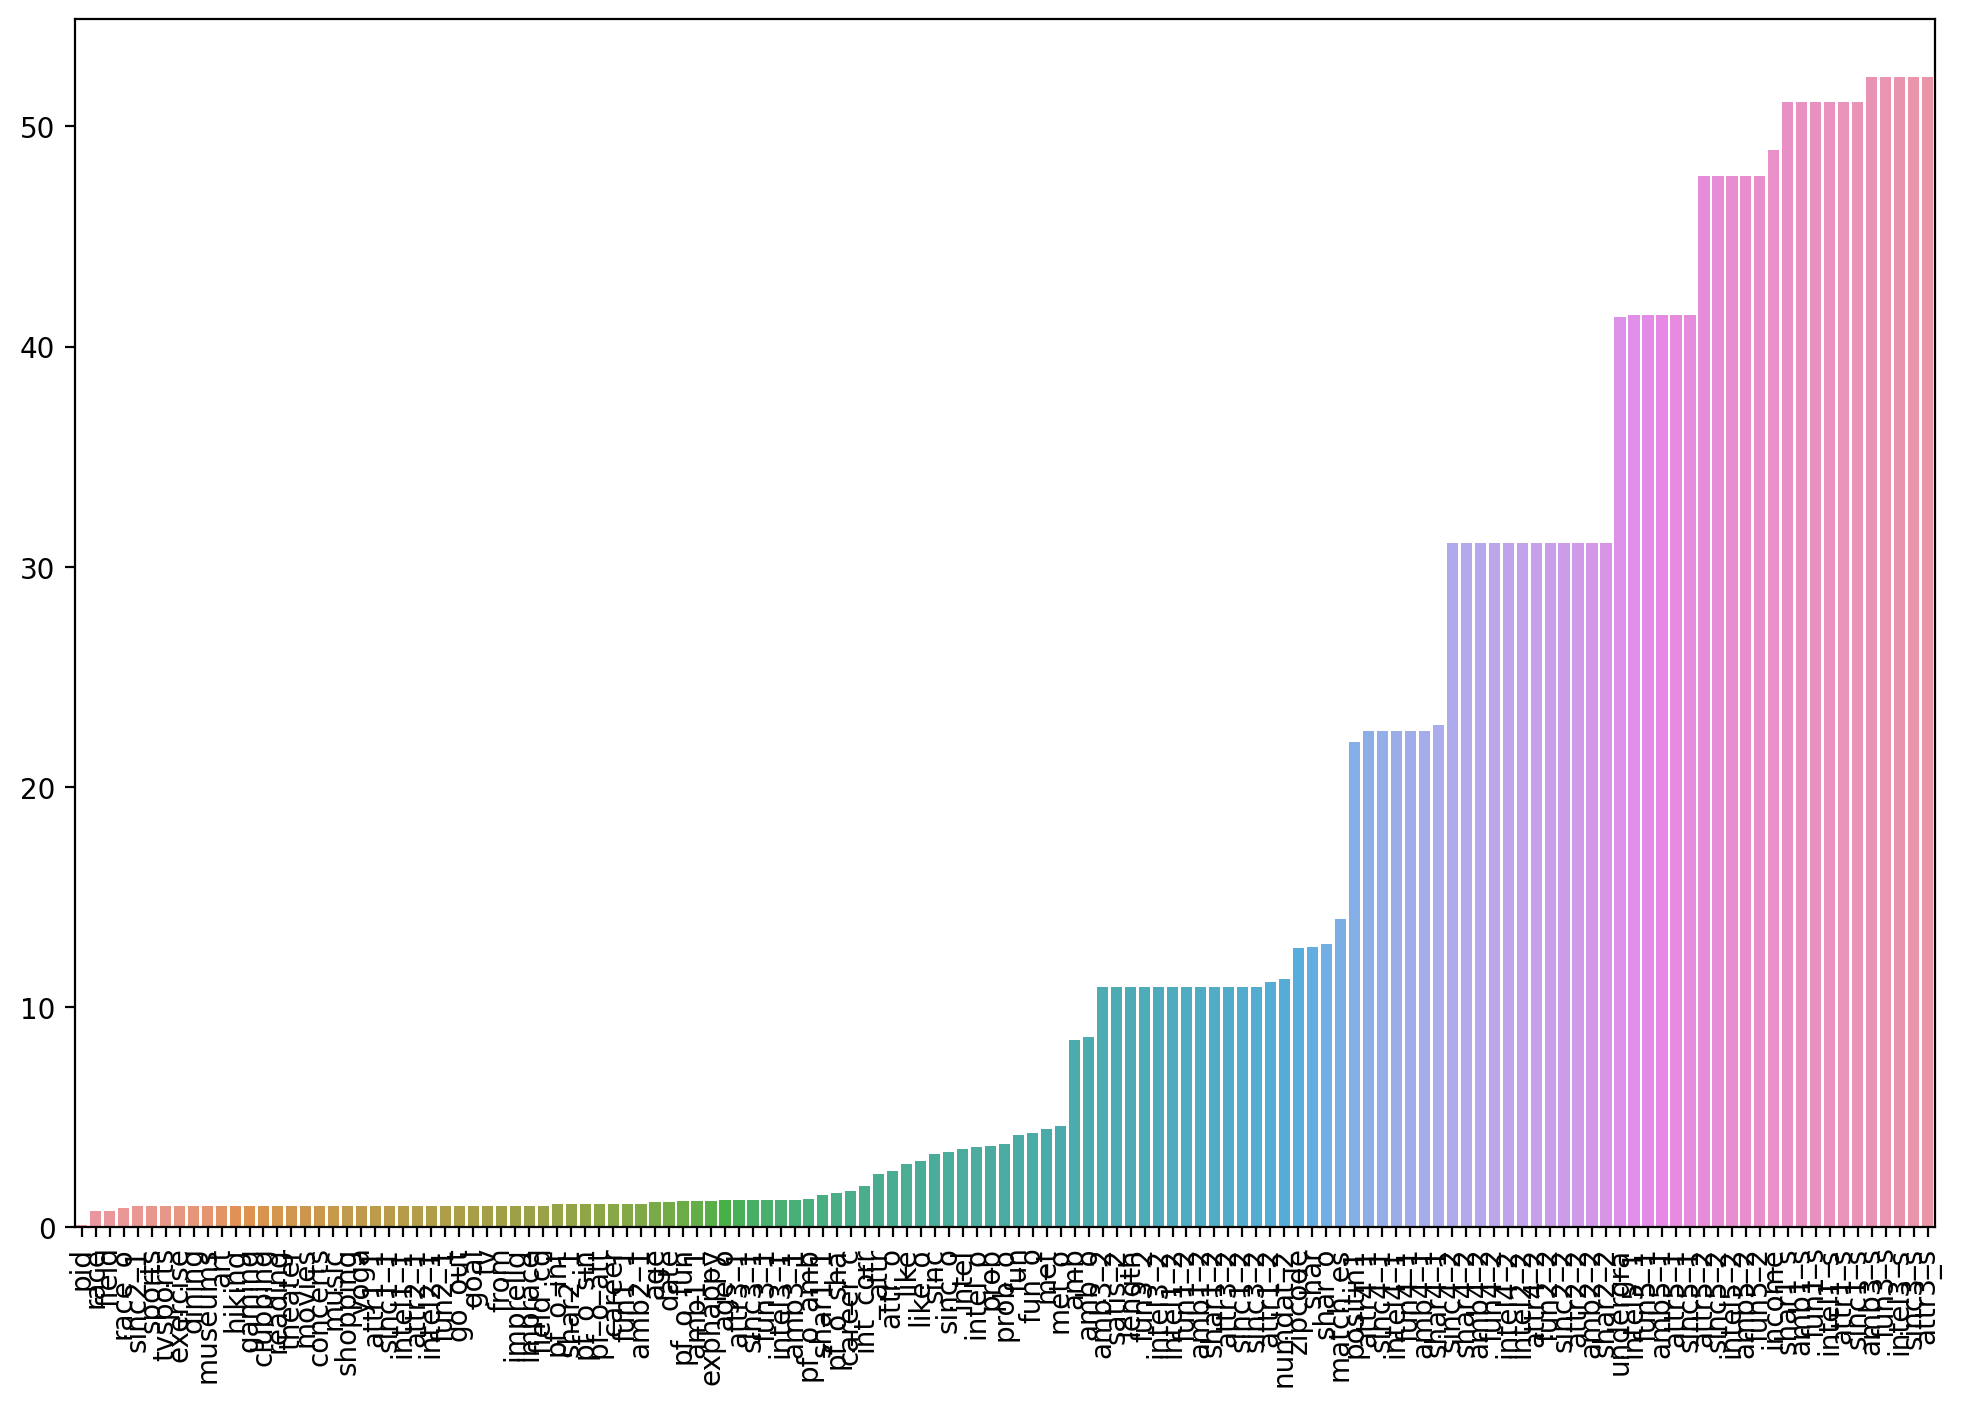

In [8]:
#Now let us look at the remaining missing data.

plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff1).index,y=percent_missing(dff1))
plt.xticks(rotation=90);

Let's examine those categories with very little missing data; perhaps there is an easy way to replace it or it is reasonable to drop.

In [14]:
percent_missing(dff1).head(10)

pid         0.119360
race        0.751969
field       0.751969
race_o      0.871330
sinc2_1     0.942946
sports      0.942946
tvsports    0.942946
exercise    0.942946
dining      0.942946
museums     0.942946
dtype: float64

In [9]:
dff1[dff1['pid'].isna()]

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2
1755,122,1,1,2,1,5,10,4,NaN,6,...,8.0,10.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN
1765,123,2,1,4,1,5,10,4,NaN,10,...,7.0,7.0,7.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN
1775,124,3,1,6,1,5,10,4,NaN,3,...,8.0,7.0,10.0,8.0,10.0,NaN,NaN,NaN,NaN,NaN
1785,125,4,1,8,1,5,10,4,NaN,8,...,9.0,7.0,9.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN
1795,126,5,1,10,1,5,10,4,NaN,1,...,8.0,10.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN
1805,127,6,1,12,1,5,10,4,NaN,7,...,8.0,5.0,10.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN
1815,128,7,1,14,1,5,10,4,NaN,9,...,8.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
1825,129,8,1,15,1,5,10,4,NaN,5,...,8.0,7.0,8.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN
1835,130,9,1,16,1,5,10,4,NaN,2,...,6.0,7.0,7.0,5.0,6.0,NaN,NaN,NaN,NaN,NaN
1845,131,10,1,18,1,5,10,4,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#It looks like person with pid=118 has no data, so we can drop these:

dff1=dff1[dff1['pid'].notnull()]

In [18]:
dff1[dff1['race'].isna()]['iid'].unique()

array([ 58,  59, 136, 339, 340, 346], dtype=int64)

In [19]:
dff1[dff1['field'].isna()]['iid'].unique()

array([ 58,  59, 136, 339, 340, 346], dtype=int64)

In [20]:
dff1[dff1['sinc2_1'].isna()]['iid'].unique()

array([ 28,  58,  59, 136, 339, 340, 346], dtype=int64)

In [79]:
#These seem to be repeat offenders. Let's consider what would happen if we simply drop these participants
dff2 = dff1[~(dff1['iid'].isin([28, 58,  59, 136, 339, 340, 346]))]
dff2 = dff2[~(dff2['pid'].isin([28, 58,  59, 136, 339, 340, 346]))]

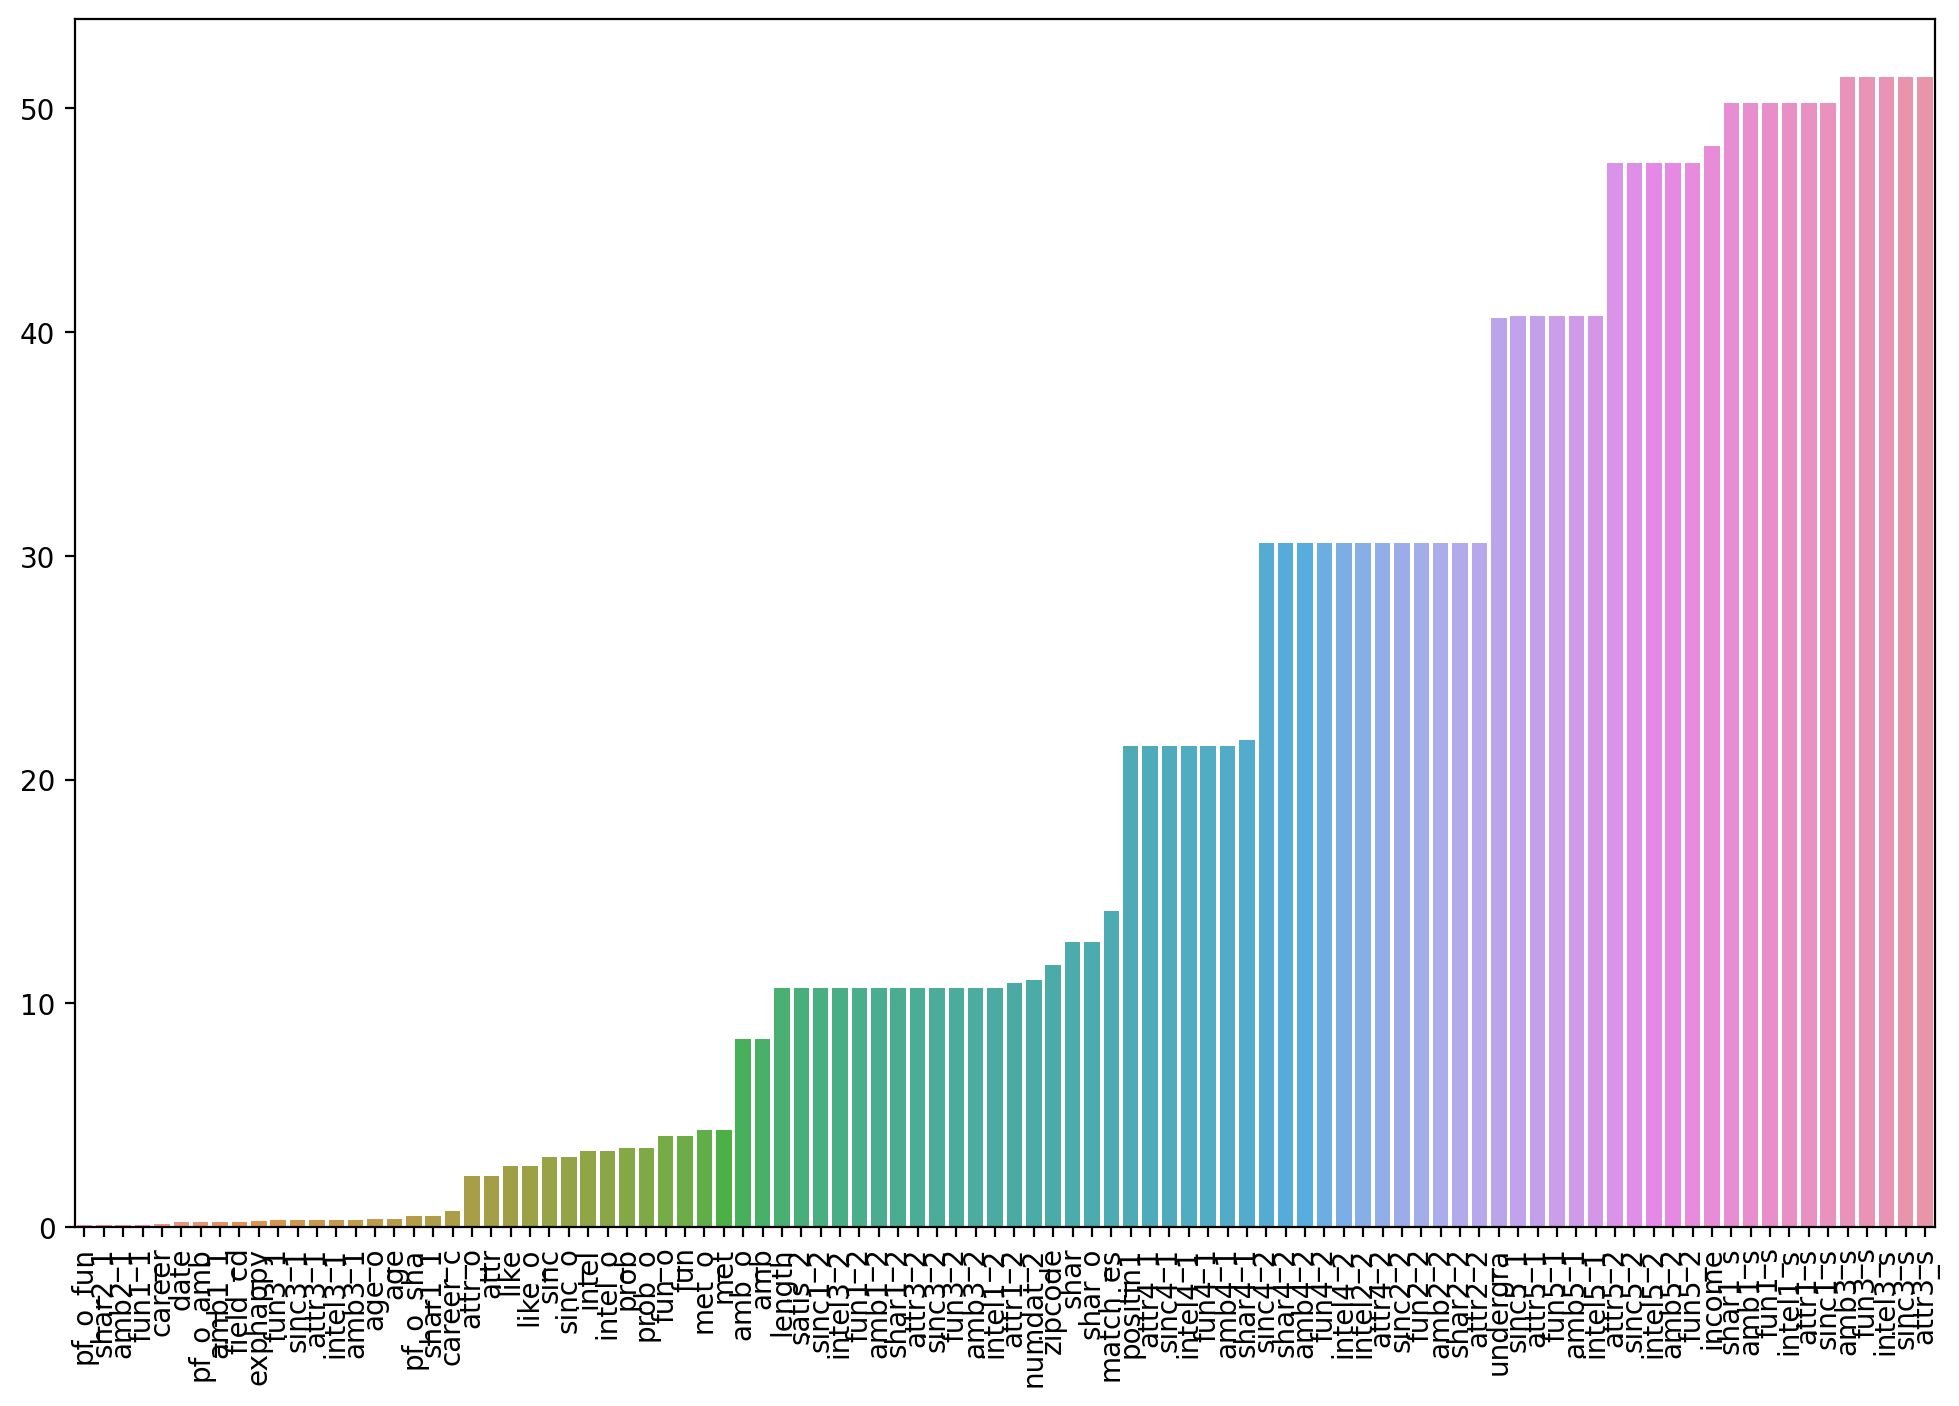

In [22]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff2).index,y=percent_missing(dff2))
plt.xticks(rotation=90);

Still, this seems like many categories to observe, many of which are not usually present.  We will remove the {_2,_3,_s} columns, which are asked either during or after the speed dates. 
We will also remove the 4_1 and 5_1, which were not asked to everyone.

In [80]:
temp= [col for col  in dff2.columns if '1_s' in col or '3_s' in col or '_2' in col or '_3' in col or '4_1' in col or '5_1' in col ]

In [81]:
dff3=dff2.drop(temp,axis=1)

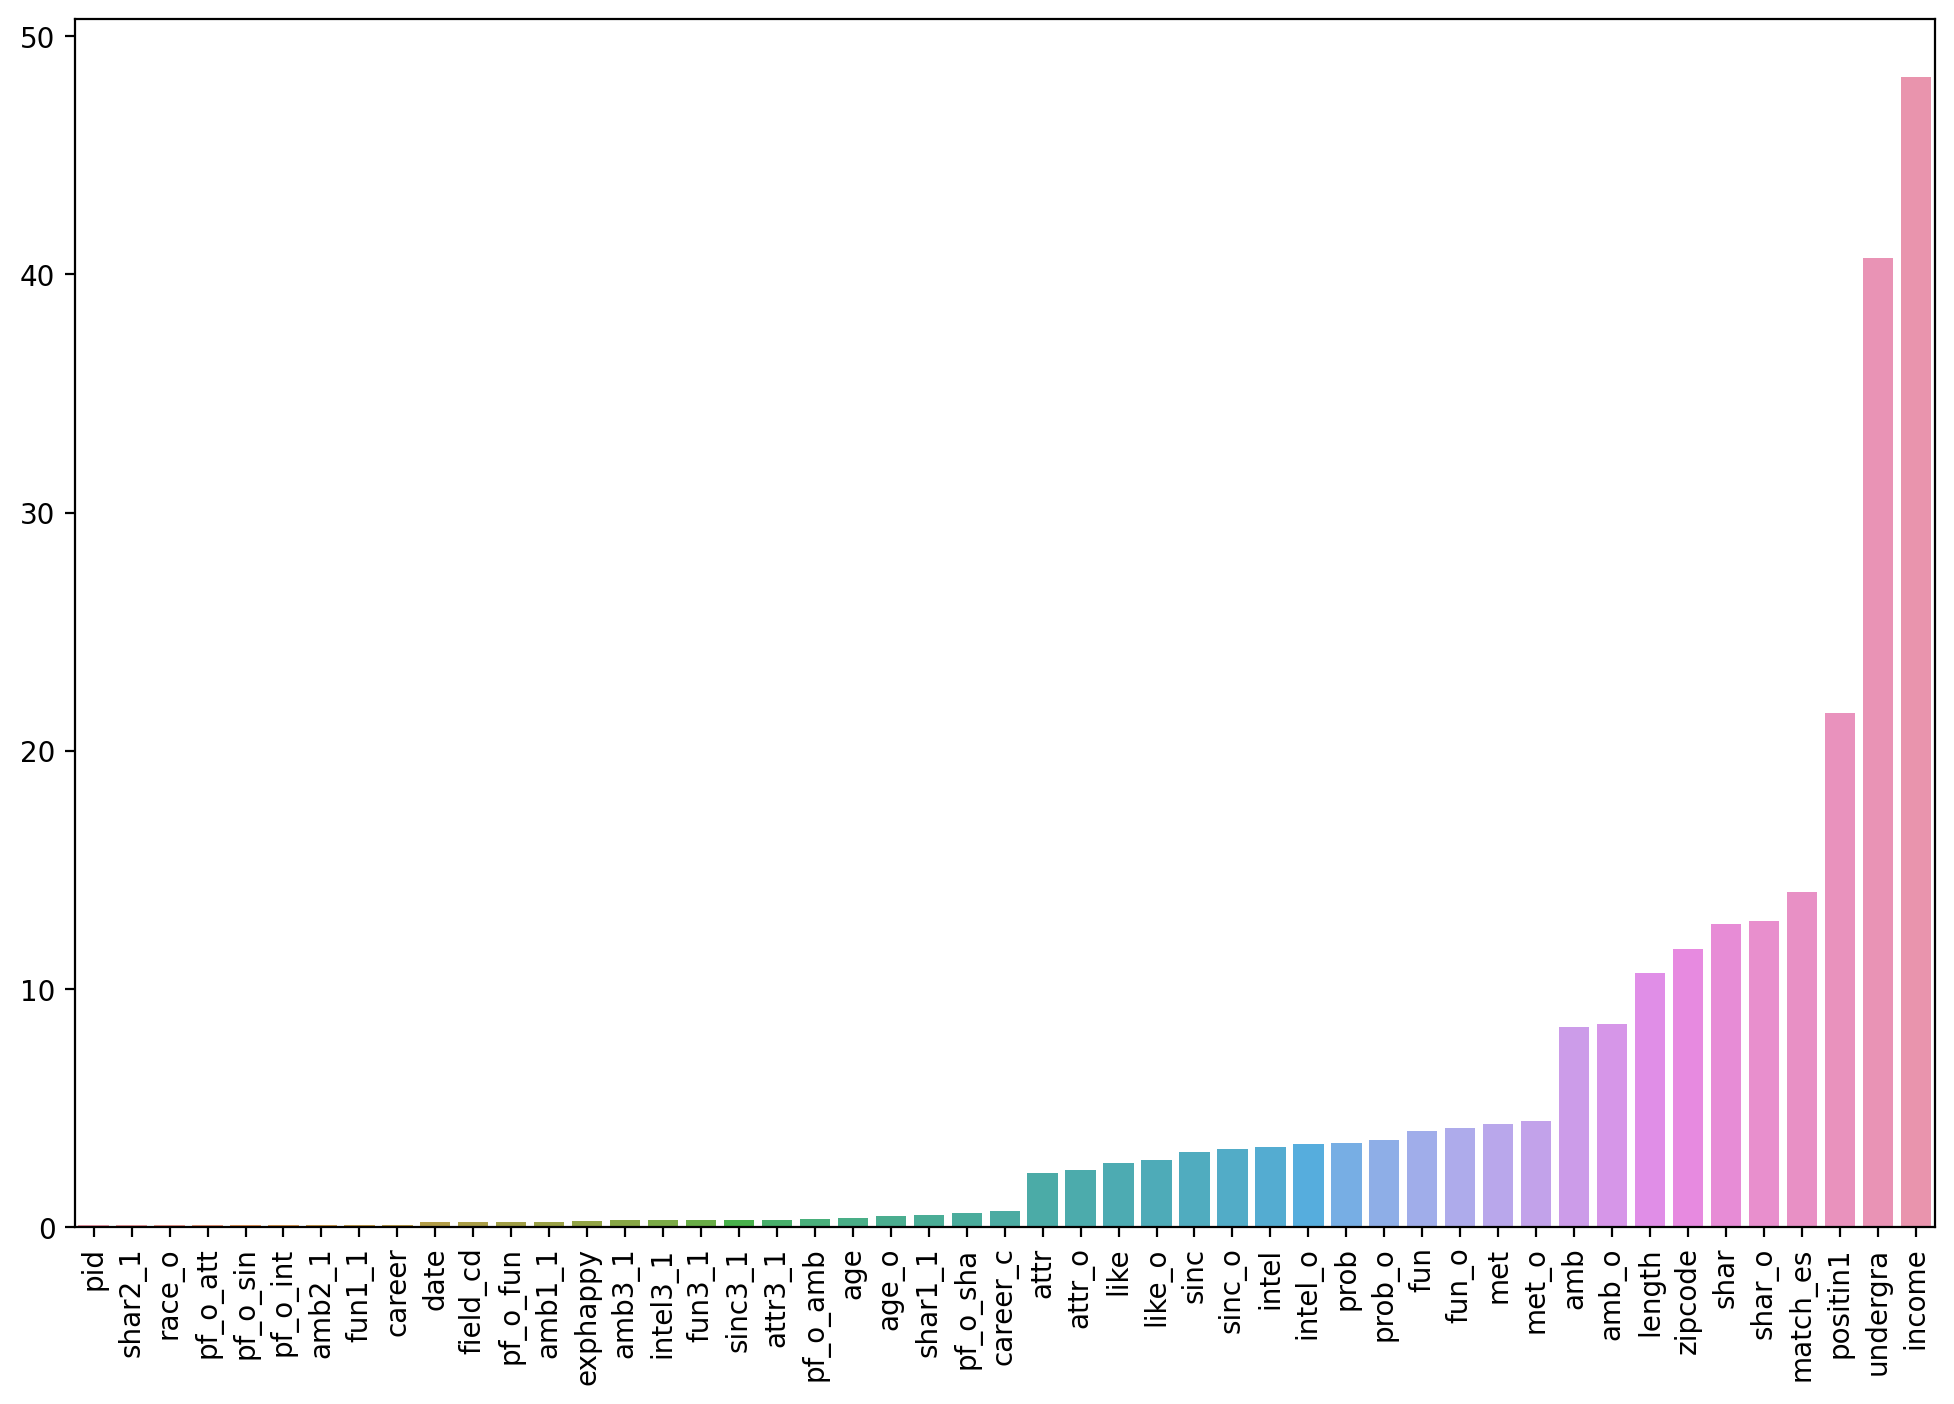

In [82]:
# Reexamine missing data
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff3).index,y=percent_missing(dff3))
plt.xticks(rotation=90);

Many of these have nothing to do with the partner evaluation, so we will remove these

In [83]:
dff4=dff3.drop(['positin1', 'undergra', 'zipcode', 'income', 'match_es','length'],axis=1)

In [32]:
for col in ['age_o','race_o','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']:
    print(col,dff4[dff4[col].isna()]['pid'].unique(),len(dff4[dff4[col].isna()]['pid'].unique()))

for col in ['gender', 'age', 'field', 'field_cd', 'race', 'imprace', 'imprelig', 
       'goal', 'date', 'go_out', 'career',
       'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
       'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
       'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy','shar1_1','sinc1_1','attr1_1','fun1_1','amb1_1','intel1_1',]:
    print(col,dff4[dff4[col].isna()]['iid'].unique(),len(dff4[dff4[col].isna()]['iid'].unique()))

age_o [129. 512.] 2
race_o [] 0
pf_o_att [] 0
pf_o_sin [] 0
pf_o_int [] 0
pf_o_fun [130.] 1
pf_o_amb [129. 130.] 2
pf_o_sha [129. 130. 528.] 3
gender [] 0
age [129 512] 2
field [] 0
field_cd [40] 1
race [] 0
imprace [] 0
imprelig [] 0
goal [] 0
date [413] 1
go_out [] 0
career [114] 1
career_c [  1   2   3  40 114] 5
sports [] 0
tvsports [] 0
exercise [] 0
dining [] 0
museums [] 0
art [] 0
hiking [] 0
gaming [] 0
clubbing [] 0
reading [] 0
tv [] 0
theater [] 0
movies [] 0
concerts [] 0
music [] 0
shopping [] 0
yoga [] 0
exphappy [512] 1
shar1_1 [129 130 528] 3
sinc1_1 [] 0
attr1_1 [] 0
fun1_1 [130] 1
amb1_1 [129 130] 2
intel1_1 [] 0


In [84]:
#We drop more repeat offenders
dff5 = dff4[~(dff4['iid'].isin([129, 130]))]
dff5 = dff5[~(dff5['pid'].isin([129, 130]))]
dff5=dff5[dff5['pid'].notnull()]

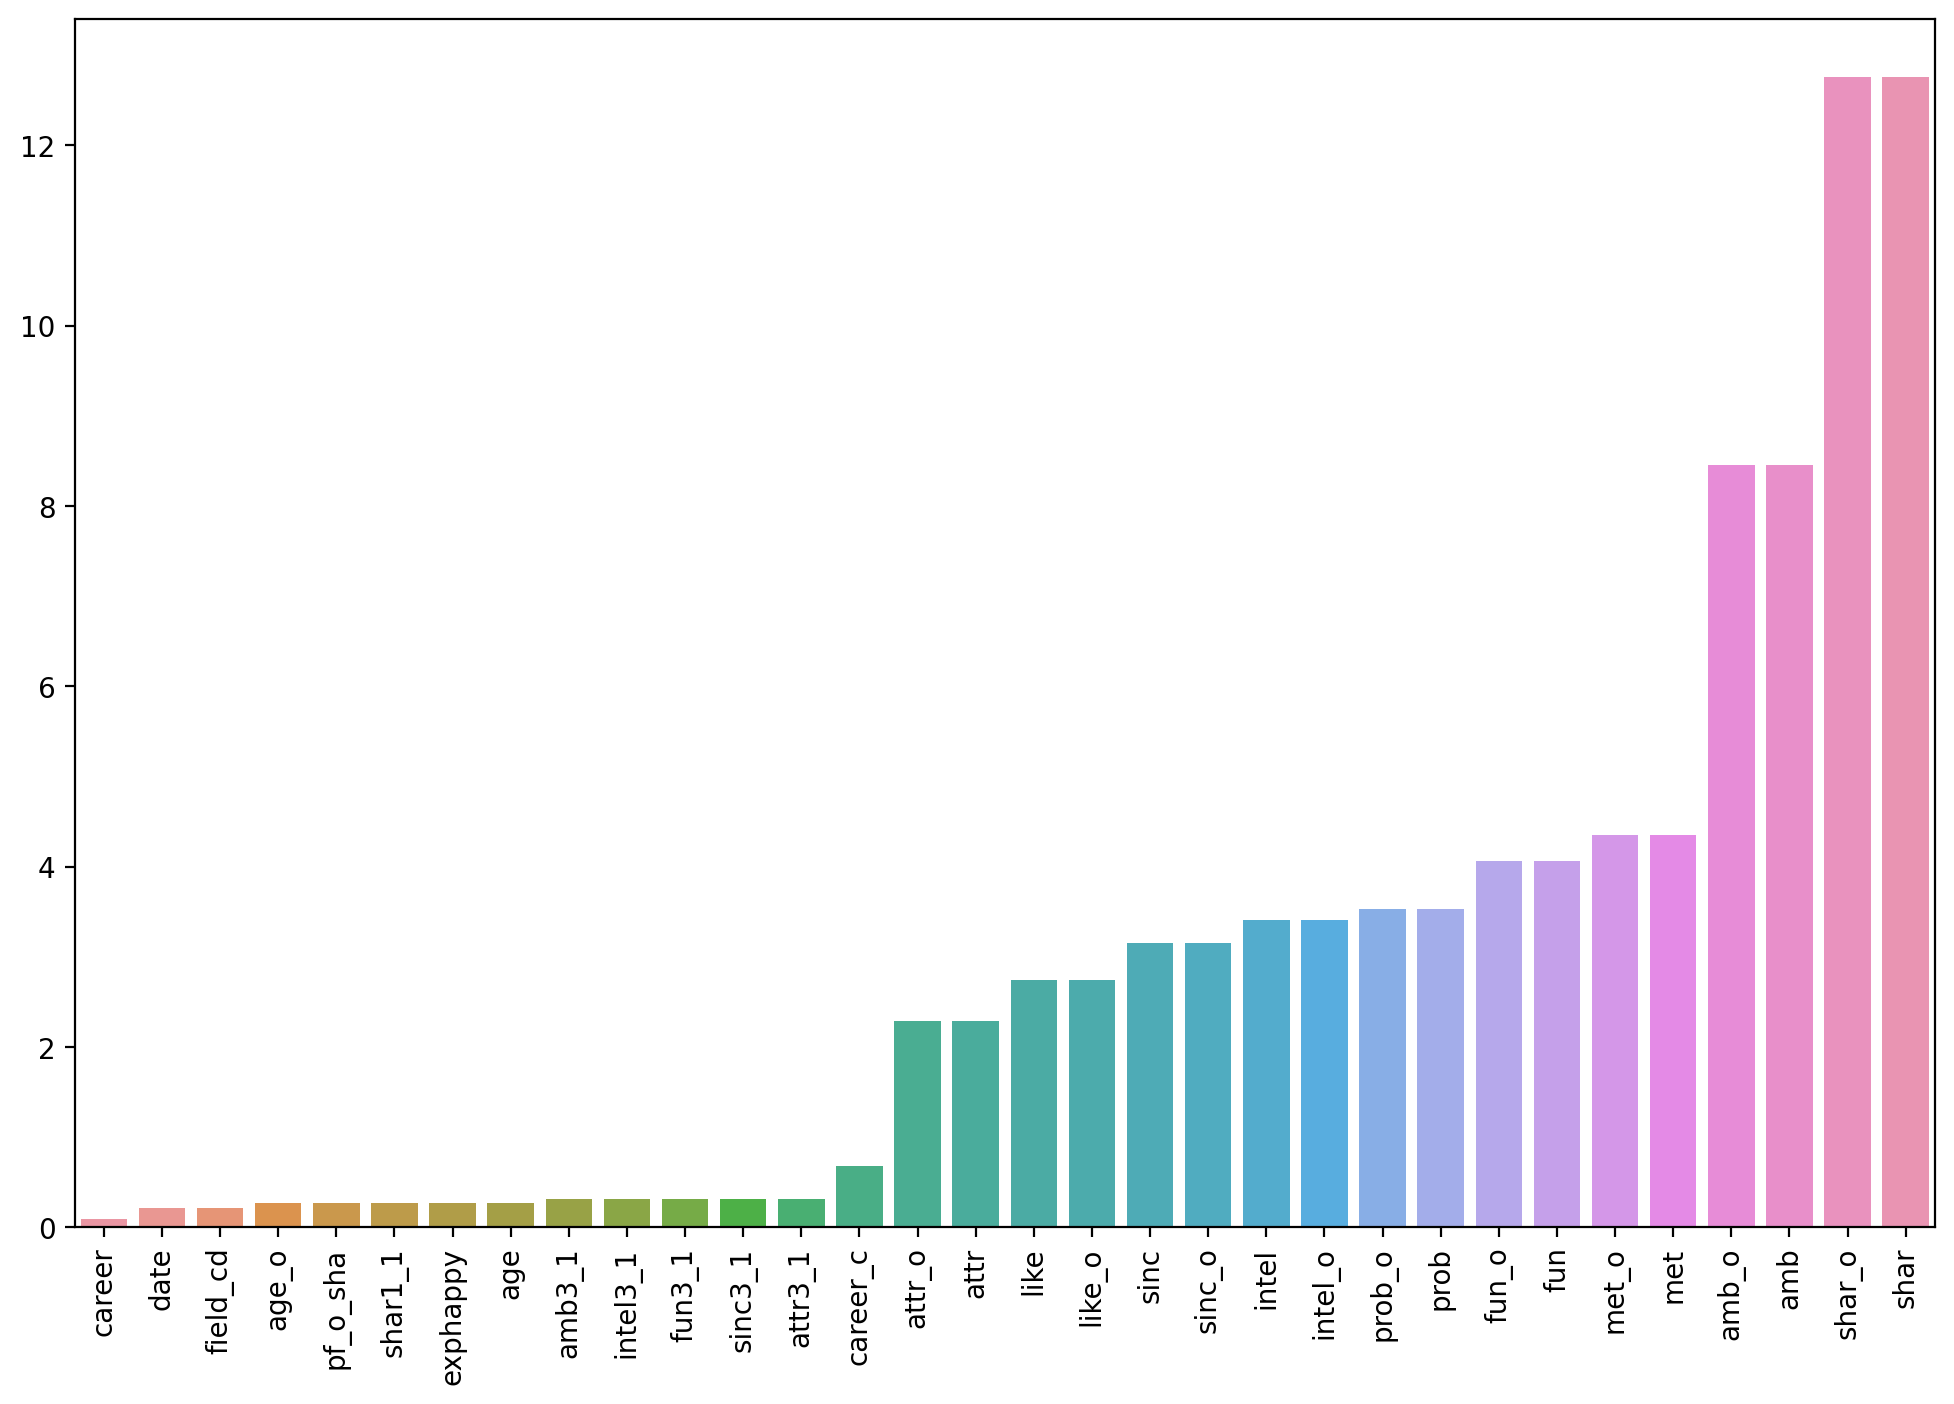

In [34]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff5).index,y=percent_missing(dff5))
plt.xticks(rotation=90);

We'll clean up some of the smaller ones, starting with career and career_c.

In [29]:
dff5[dff5['career_c'].isnull()]['iid'].unique()

array([  1,   2,   3,  40, 114], dtype=int64)

In [31]:
dff5[dff5['iid'].isin([1,2,3,40,114])]['career']

0                  lawyer
1                  lawyer
2                  lawyer
3                  lawyer
4                  lawyer
5                  lawyer
6                  lawyer
7                  lawyer
8                  lawyer
9                  lawyer
10                    law
11                    law
12                    law
13                    law
14                    law
15                    law
16                    law
17                    law
18                    law
19                    law
20              Economist
21              Economist
22              Economist
23              Economist
24              Economist
25              Economist
26              Economist
27              Economist
28              Economist
29              Economist
504     tech professional
505     tech professional
506     tech professional
507     tech professional
508     tech professional
509     tech professional
510     tech professional
512     tech professional
513     tech

In [85]:
# The missing career is labelled unknown, and the remaining career codes are filled in.
dff5['career']=dff5['career'].fillna('Unknown')
dff5['career_c'].iloc[0:20]=dff5['career_c'].iloc[0:20].fillna(1)
dff5['career_c'].iloc[20:30]=dff5['career_c'].iloc[20:30].fillna(2)
dff5['career_c'].loc[504:510]=dff5['career_c'].loc[504:510].fillna(5)
dff5['career_c'].loc[512:521]=dff5['career_c'].loc[512:521].fillna(5)
dff5['career_c'].loc[522]=5
dff5['career_c'].loc[1676:1683]=dff5['career_c'].loc[1676:1683].fillna(10)
dff5['career_c'].loc[1685]=10

C:\Users\charl\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


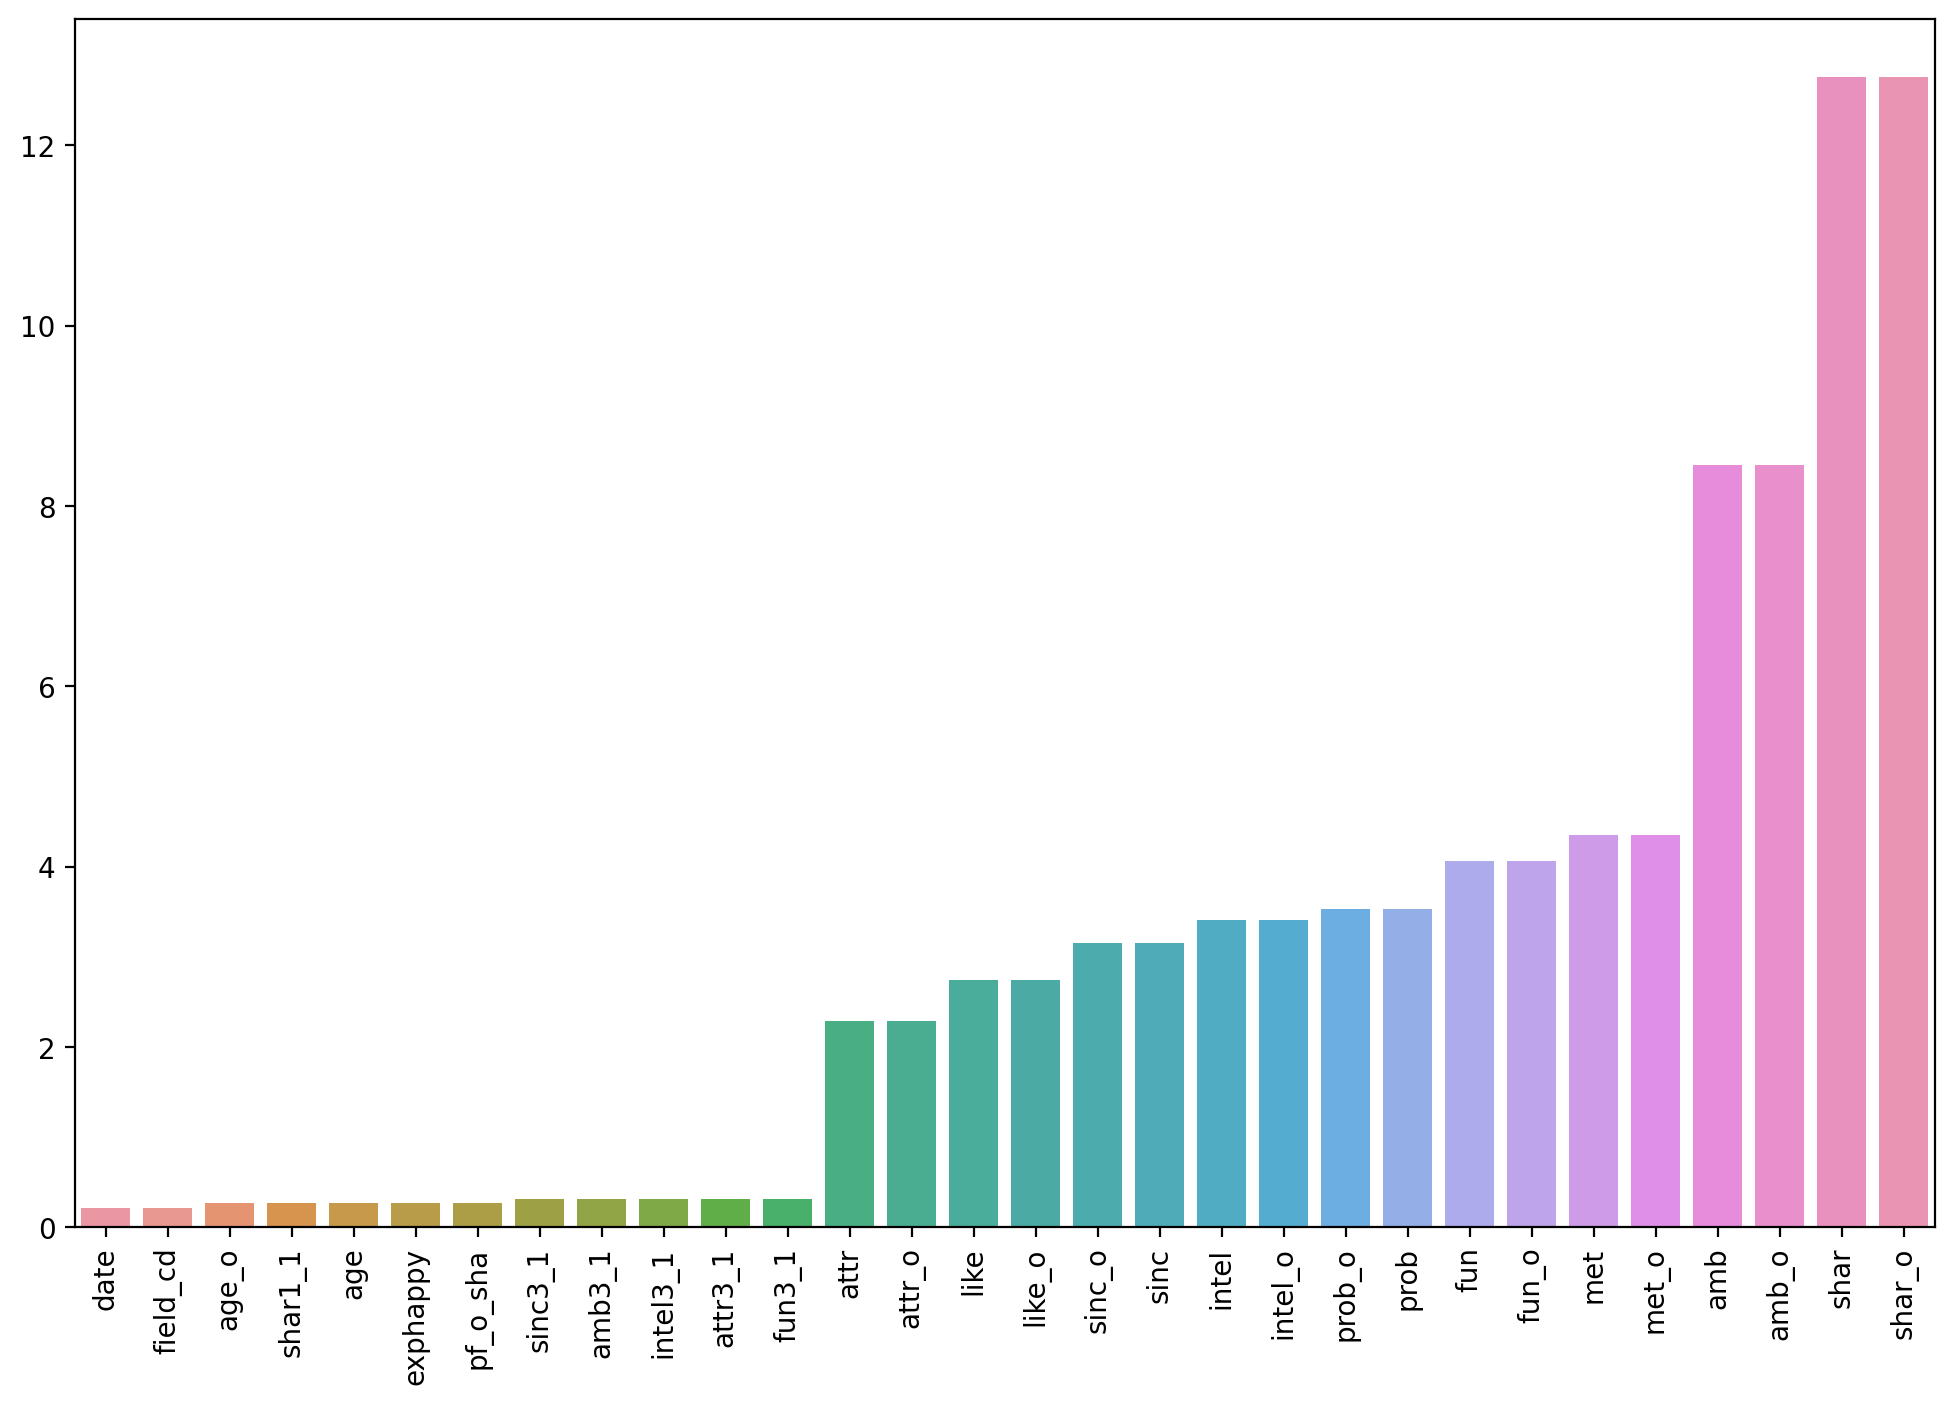

In [58]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff5).index,y=percent_missing(dff5))
plt.xticks(rotation=90);

In [91]:
# We also drop the following, which don't really contribute to a partner's decision
dff5=dff5.drop(['date','amb3_1','fun3_1','attr3_1','sinc3_1','intel3_1','exphappy'],axis=1)


In [104]:
dff5=dff5.drop(['prob','prob_o'],axis=1)

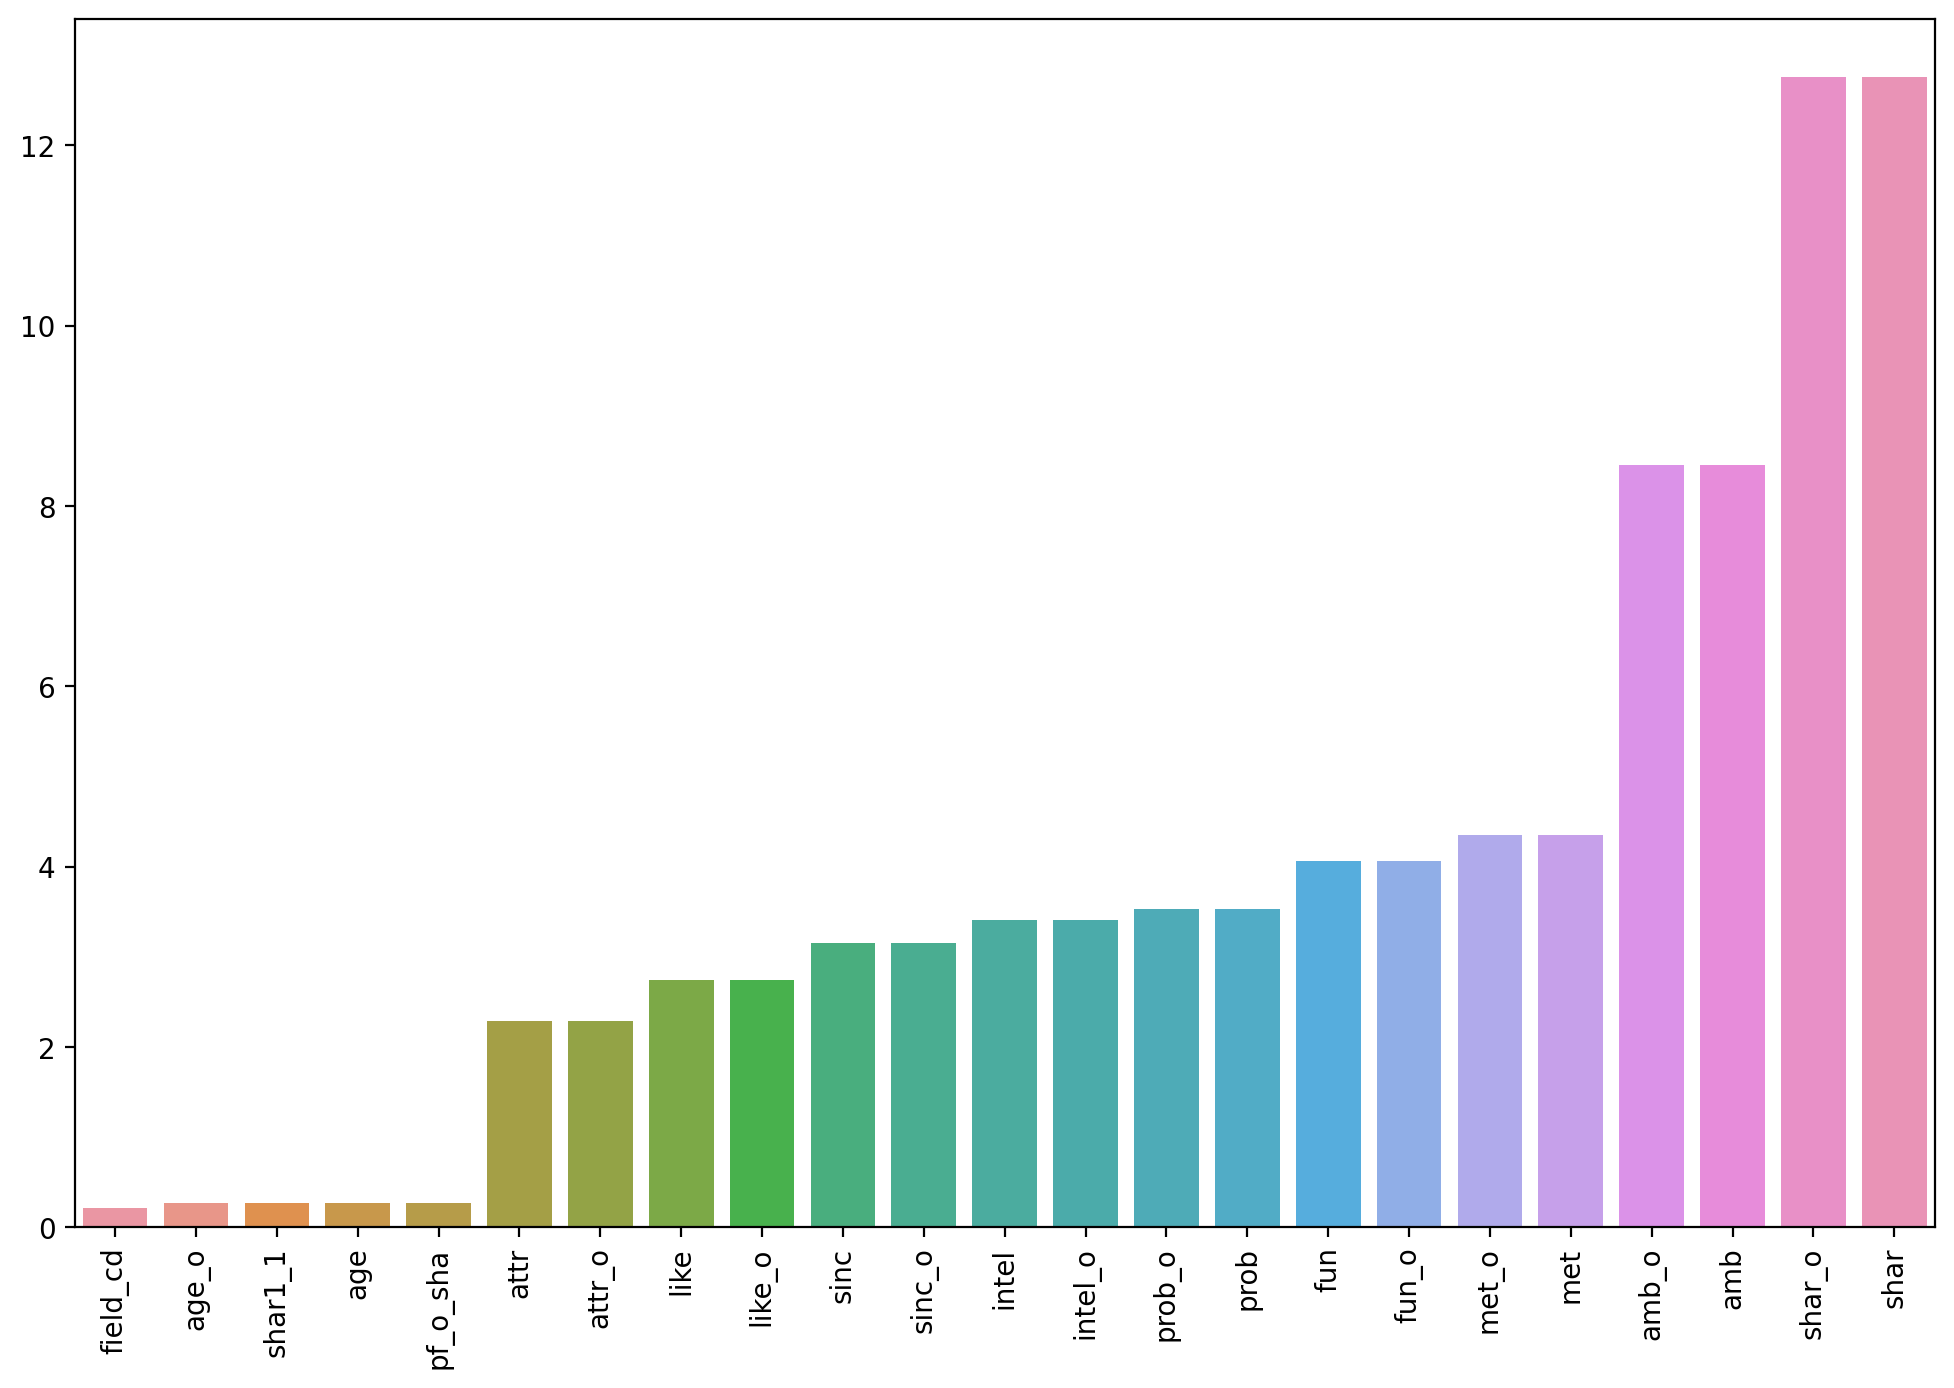

In [60]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff5).index,y=percent_missing(dff5))
plt.xticks(rotation=90);

In [62]:
dff5[dff5['age'].isnull()]['iid']

7476    512
7477    512
7478    512
7479    512
7480    512
7481    512
7482    512
7483    512
7484    512
7485    512
7486    512
7487    512
7488    512
7489    512
7490    512
7491    512
7492    512
7493    512
7494    512
7495    512
7496    512
7497    512
Name: iid, dtype: int64

In [86]:
# Other person in MFA Acting Program is 23, so we may assume 512 is also 23?
dff5['age']=dff5['age'].fillna(23)

dff5['age_o']=dff5['age_o'].fillna(23)

In [87]:
dff5[dff5['field_cd'].isna()][['iid','field']]

,iid,field
504,40,Operations Research
505,40,Operations Research
506,40,Operations Research
507,40,Operations Research
508,40,Operations Research
509,40,Operations Research
510,40,Operations Research
512,40,Operations Research
513,40,Operations Research
514,40,Operations Research


In [88]:
dff5['field_cd']=dff5['field_cd'].fillna(5)

In [77]:
dff5[dff5['shar1_1'].isnull()]

,iid,id,gender,idg,condtn,wave,round,position,order,partner,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
7828,528,20,0,39,2,21,22,19,6,1,...,0,1.0,5.0,8.0,1.0,8.0,1.0,1.0,1.0,0.0
7829,528,20,0,39,2,21,22,19,3,2,...,0,1.0,5.0,8.0,1.0,9.0,1.0,1.0,1.0,0.0
7830,528,20,0,39,2,21,22,19,18,3,...,0,3.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,0.0
7831,528,20,0,39,2,21,22,19,5,4,...,0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0
7832,528,20,0,39,2,21,22,19,2,5,...,0,2.0,2.0,7.0,1.0,8.0,1.0,1.0,1.0,0.0
7833,528,20,0,39,2,21,22,19,17,6,...,0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,0.0
7834,528,20,0,39,2,21,22,19,7,7,...,0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,0.0
7835,528,20,0,39,2,21,22,19,12,8,...,0,2.0,4.0,3.0,6.0,1.0,2.0,2.0,2.0,0.0
7836,528,20,0,39,2,21,22,19,16,9,...,0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0
7837,528,20,0,39,2,21,22,19,9,10,...,0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,0.0


In [89]:
dff5[dff5['iid'].isin([528])][['amb1_1','sinc1_1','fun1_1','attr1_1','intel1_1']]

#Since these add to 100, I suppose it makes sense to assume shar1_1 for iid 528 is 0
dff5['shar1_1']=dff5['shar1_1'].fillna(0)

dff5['pf_o_sha']=dff5['pf_o_sha'].fillna(0)

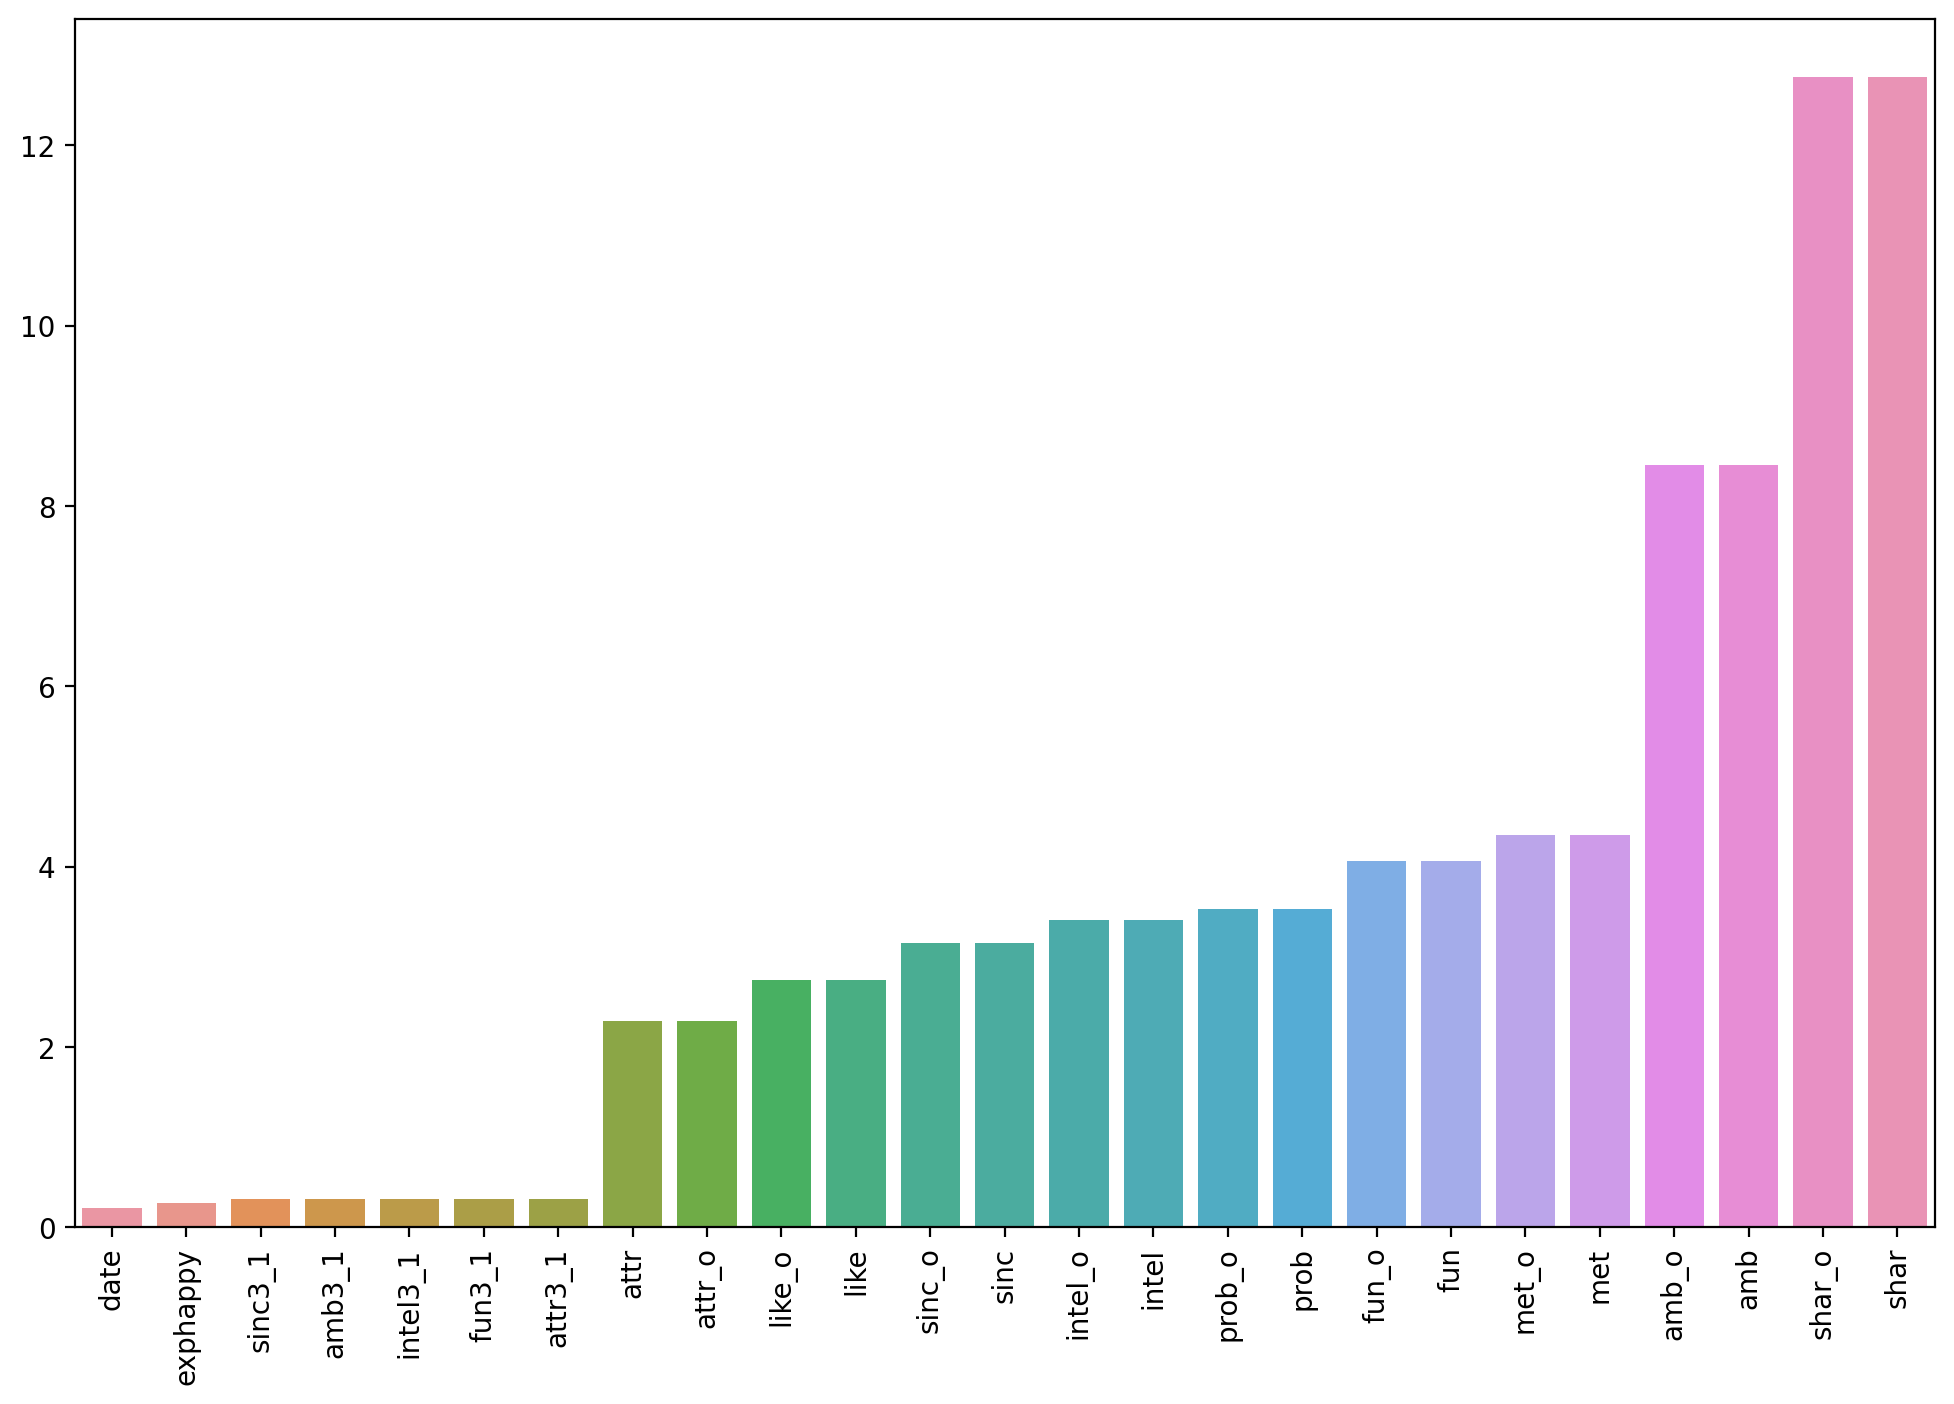

In [90]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff5).index,y=percent_missing(dff5))
plt.xticks(rotation=90);

### Met or not?

In [84]:
dff5['met'].unique()

array([ 2.,  1., nan,  3.,  5.,  0.,  7.,  8.,  6.])

In [85]:
dff5['met_o'].unique()

array([ 2.,  1., nan,  3.,  5.,  6.,  7.,  8.])

In [86]:
#It appears there are some entries that are not 1 or 2 (Why are there numbers greater than 2?).  Let's focus on the entries that are only 1 or 2.
dff_met=dff5[((dff5['met']==1) | (dff5['met']==2)) & ((dff5['met_o']==1) | (dff5['met_o']==2))]

len(dff_met)

3712

In [87]:
#Among those that have both valid met and met_o entries, how many agree on whether they both either met or didn't meet?
dff_met_agreement=dff_met[dff_met['met']==dff_met['met_o']]
len(dff_met_agreement)/len(dff_met)*100

97.2790948275862

It seems that among the people with valid met and met_o entries, almost all (97%) agree on whether they have met or not.
So for those with invalid met and met_o entries, it is reasonable to assign them to the other.

In [92]:
def fill_met(a,b):
    if a!=1 and a!=2:
        return b
    else:
        return a

In [93]:
dff5['met']=dff5[['met','met_o']].apply(lambda dff5:fill_met(dff5['met'],dff5['met_o']),axis=1)

dff5['met_o']=dff5[['met','met_o']].apply(lambda dff5:fill_met(dff5['met_o'],dff5['met']),axis=1)

In [94]:
dff5['met'].unique()

array([ 2.,  1., nan,  5.])

In [92]:
dff5['met_o'].unique()

array([ 2.,  1., nan,  5.])

So there are still some problematic entries. Let's look at them:

In [93]:
dff5[~(((dff5['met']==1) | (dff5['met']==2)) & ((dff5['met_o']==1) | (dff5['met_o']==2)))][['met','met_o']]

,met,met_o
1695,NaN,NaN
1839,NaN,NaN
2242,NaN,NaN
2386,NaN,NaN
2913,NaN,NaN
...,...,...
8302,NaN,NaN
8344,NaN,NaN
8359,NaN,NaN
8366,NaN,NaN


From here we have 2 options: We could either replace all of these with 2, or drop them.
We will go with the first, replacing them all with 2.

In [95]:
dff5['met']=dff5['met'].fillna(2)
dff5['met_o']=dff5['met_o'].fillna(2)

In [95]:
dff5['met_o'].unique()

array([2., 1., 5.])

In [96]:
dff5['met_o'].unique()

array([2., 1., 5.])

In [97]:
dff5[dff5['met_o']==5][['met','met_o']]

,met,met_o
8053,5.0,5.0


In [96]:
dff5['met'].loc[8053]=2
dff5['met_o'].loc[8053]=2

C:\Users\charl\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [105]:
#Let's rename dff5 this after these changes
dff6=dff5

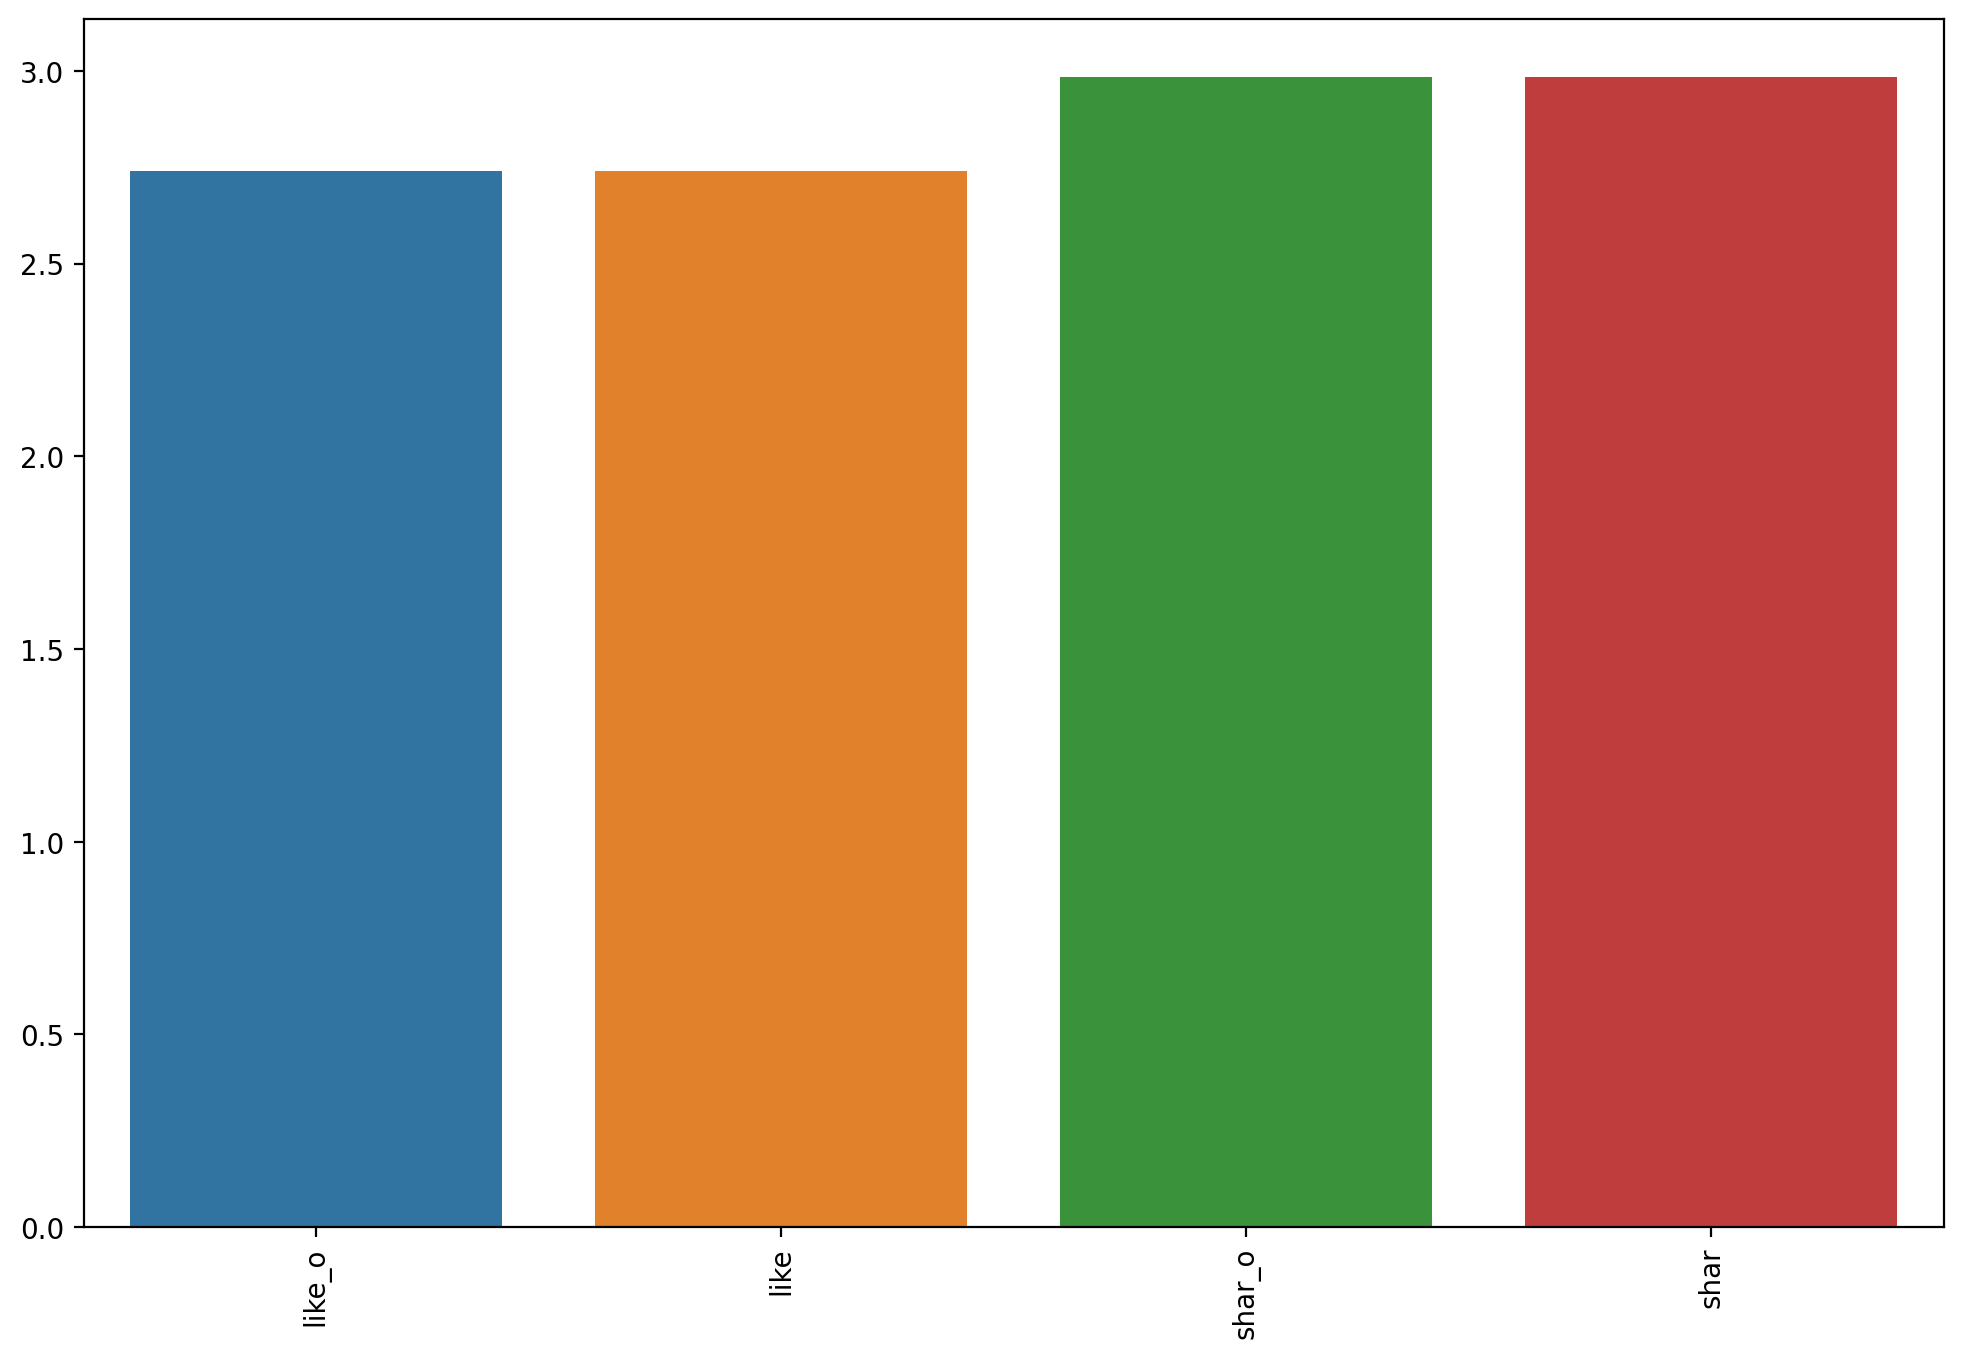

In [125]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff6).index,y=percent_missing(dff6))
plt.xticks(rotation=90);

### Extrapolating for the remaining missing data

The biggest remaining missing column is shar.  One might think that if person 1 has some share value with person 2, the reverse might be similar.  Let's test that:

In [105]:
share_difference=[]
for i in range(len(dff6[dff6['wave']==1])):
     share_difference.append(abs(dff6['shar'][i]-dff6['shar_o'][i]))

In [106]:
pd.DataFrame(share_difference).describe()

,0
count,182.000000
mean,2.032967
std,1.755500
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,8.000000


In [107]:
pd.DataFrame(share_difference).value_counts()

1.0    42
0.0    40
2.0    36
3.0    32
4.0    12
5.0    12
6.0     6
8.0     2
dtype: int64

It appears that most people rated their shared interests close to each other, so we will assume it is reasonable to copy one from the other.

In [98]:
def fill_shar(a,b):
    if pd.isna(a):
        return b
    else:
        return a

In [106]:
dff7=dff6

In [107]:
dff7['shar']=dff7[['shar','shar_o']].apply(lambda dff7:fill_shar(dff7['shar'],dff7['shar_o']),axis=1)
dff7['shar_o']=dff7[['shar','shar_o']].apply(lambda dff7:fill_shar(dff7['shar_o'],dff7['shar']),axis=1)

For attraction, sincerity, intellegence, fun, and ambition, we will take the average of their ratings from the other people who evaluated them to fill in the missing data.

In [108]:
for col in ['attr','sinc','intel','fun','amb']: 
    for pid in dff7['pid'].unique():
        if dff7.loc[dff7[dff7['pid']==pid].index,col].isnull().any():
            dff7.loc[dff7[dff7['pid']==pid].index,col]=dff7.loc[dff7[dff7['pid']==pid].index,col].fillna(dff7.loc[dff7[dff7['pid']==pid].index,col].mean())

In [109]:
for col in ['attr_o','sinc_o','intel_o','fun_o','amb_o']: 
    for iid in dff7['iid'].unique():
        if dff7.loc[dff7[dff7['iid']==iid].index,col].isnull().any():
            dff7.loc[dff7[dff7['iid']==iid].index,col]=dff7.loc[dff7[dff7['iid']==iid].index,col].fillna(dff7.loc[dff7[dff7['iid']==iid].index,col].mean())


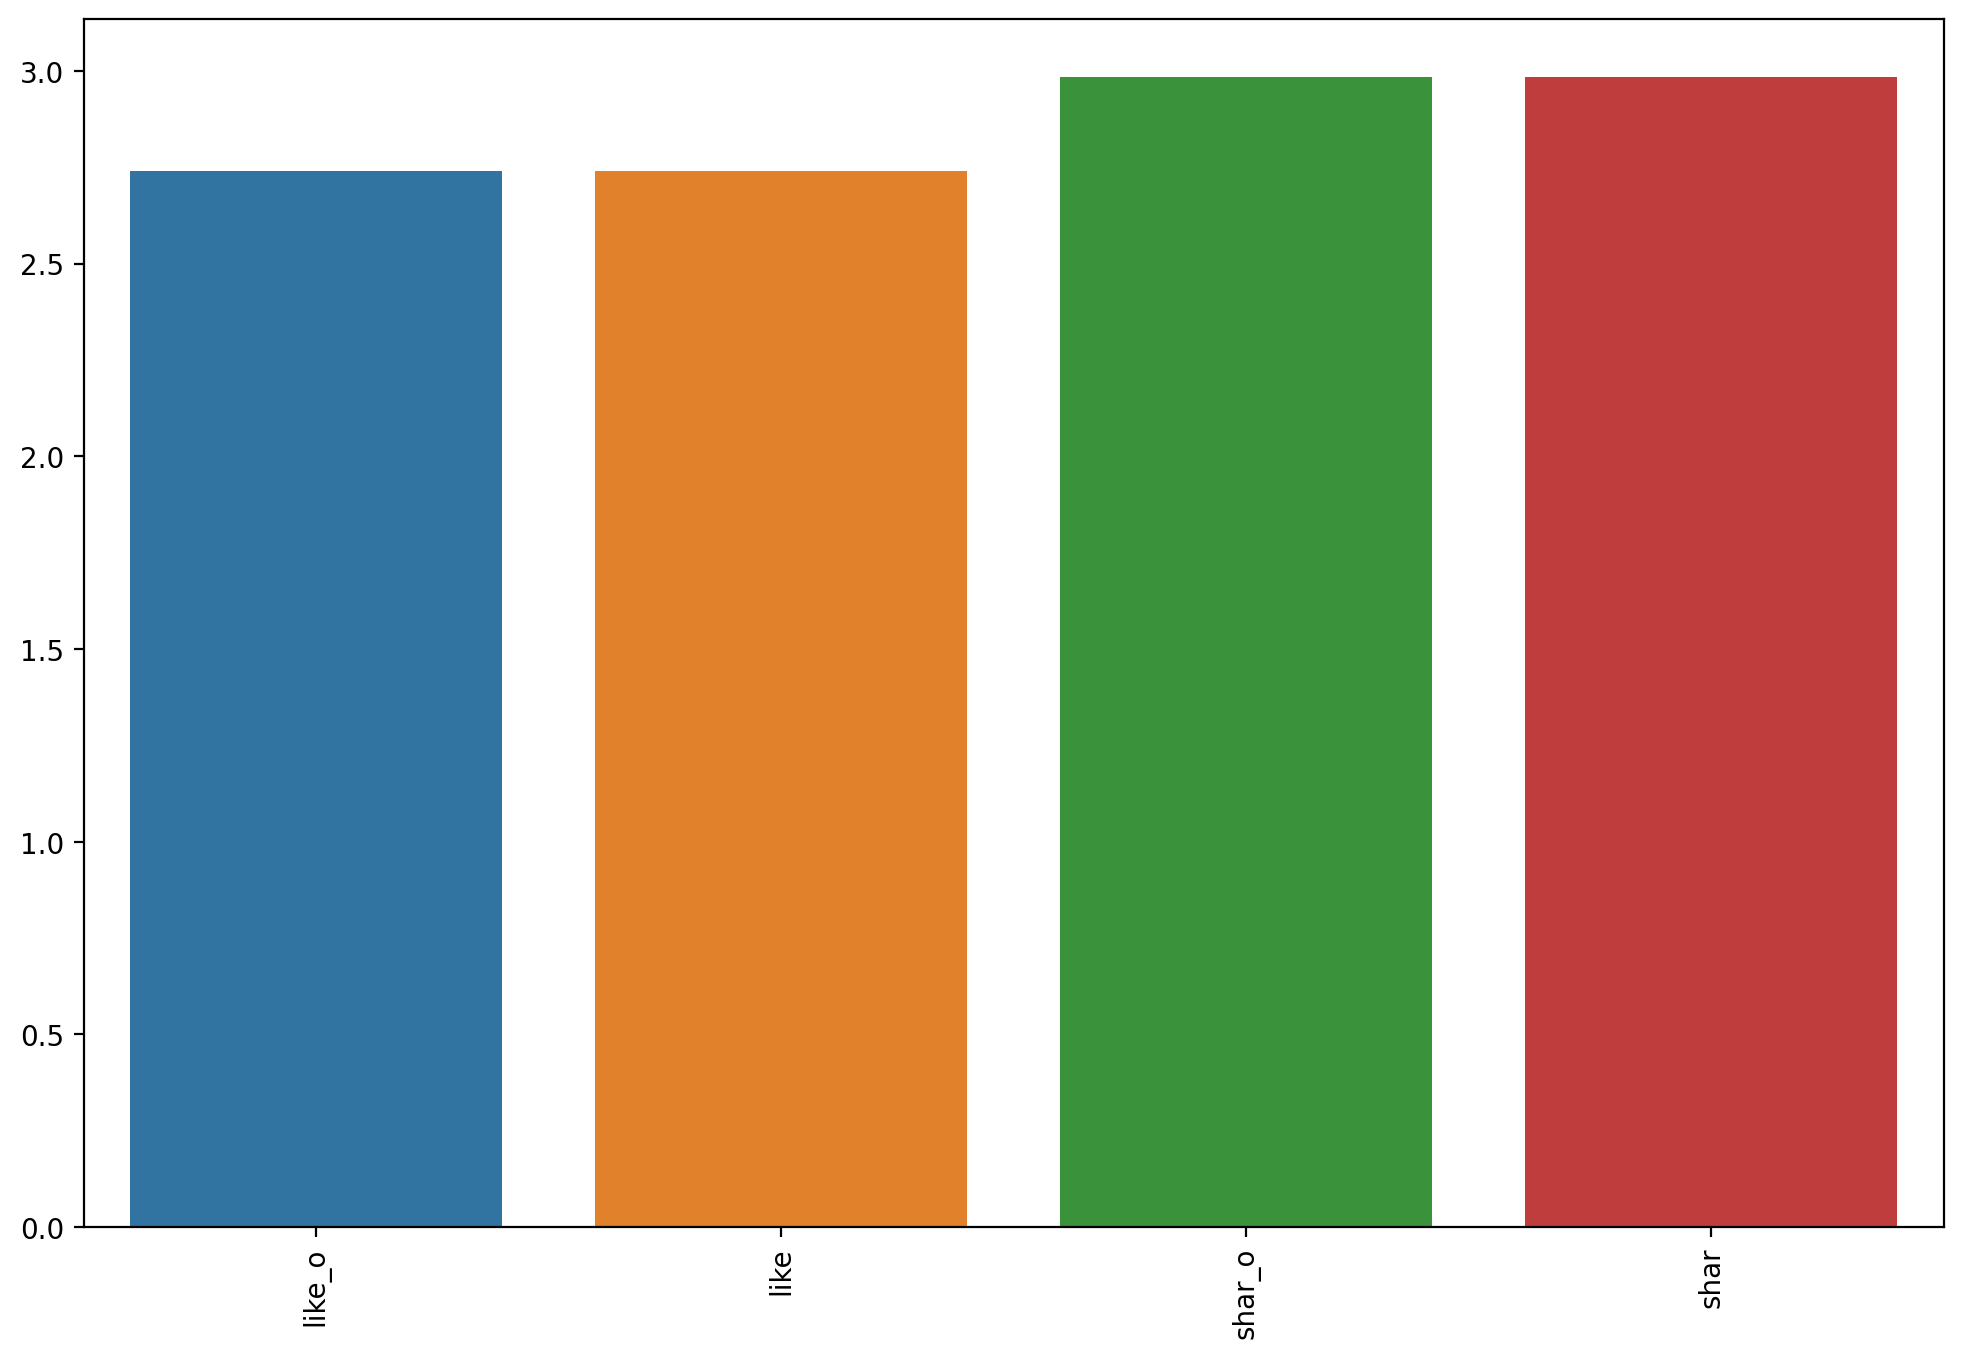

In [110]:
plt.figure(figsize=(12,8),dpi=200)
sns.barplot(x=percent_missing(dff7).index,y=percent_missing(dff7))
plt.xticks(rotation=90);

In [119]:
#I couldn't think of ways to interpolate like or shared interests, so I just dropped these rows
dff8=dff7[~((dff7['shar'].isnull()))]
dff8=dff8[~(dff8['like'].isnull())]

# The analysis of the data:  <a id="analysis"></a>
### We will use Random Forest to find important features determining whether a person accepted a match or not.

In [171]:
#We drop redundant characteristics or preferences from the other person
X = pd.get_dummies(dff8.drop(['dec','match','pid','partner','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','attr_o','sinc_o','intel_o','fun_o','amb_o','shar_o','like_o'],axis=1))
y = dff8['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

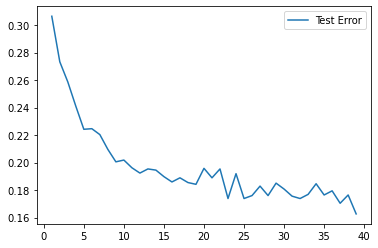

In [172]:
test_error = []

for n in range(1,40):
    # Use n random trees
    model = RandomForestClassifier(n_estimators=n,max_features='auto')
    model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    test_error.append(1-accuracy_score(test_preds,y_test))
 

plt.plot(range(1,40),test_error,label='Test Error')
plt.legend()

In [173]:
#A reasonable choice for the number of trees is 23 based on the graph
model = RandomForestClassifier(n_estimators=23,max_features='auto')
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=23)

In [174]:
preds=model.predict(X_test)
confusion_matrix(y_test,preds)

array([[1122,  165],
       [ 241,  796]], dtype=int64)

In [175]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1287
           1       0.83      0.77      0.80      1037

    accuracy                           0.83      2324
   macro avg       0.83      0.82      0.82      2324
weighted avg       0.83      0.83      0.82      2324



In [176]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance').tail(10)

,Feature Importance
amb,0.025344
sinc,0.026190
intel,0.026277
age_o,0.029783
order,0.033014
int_corr,0.033576
shar,0.054061
fun,0.068521
attr,0.086724
like,0.091147


#### It appears like attraction and seem to be the most important characteristics. Let's see what happens if we compare the two dating app methods: First is where only one gender is optimized on compatibility;we will optimize for women. The second is where both methods are optimized for compatibility.

# Matching Algorithms <a id="algorithms"></a>

#### First, let's see the best matching we can do give our dataset.  In other words, what is the maximum number of matches we could make where both people accepted? We will create a bipartite graph, where each edge between a man and a woman represents a mutually accepted match, and then find the size of a maximum matching.

In [121]:
edges=[]
for i in range(1,22):
    edges.append([(iid,pid) for iid in dff7[dff7['wave']==i]['iid'].unique() for pid in dff7[dff7['wave']==i]['pid'].unique() if pid in list(dff7[(dff7['iid']==iid)&(dff7['match']==1)]['pid'])])

G=[]
for i in range(21):
    G.append(nx.Graph(edges[i]))    

Connected_comps = [nx.induced_subgraph(Graph,vertices) for Graph in G for vertices in list(nx.connected_components(Graph))]

max_match=0
for Graph in Connected_comps:
    max_match+=len(nx.bipartite.maximum_matching(Graph))/2

max_match

198.0

In [123]:
# Consider this ratio to the total number of women.
round(max_match/len(dff7[dff7['gender']==0]['iid'].unique())*100,1)

73.6

The best we could do is 73.6% of woman in a mutual match.  Let' see how our algorithms perform:

## 1. Algorithm is optimized for women. <a id="women only"></a>

### We create a weighted graph, where the nodes correspond to the participants, and the weighted edge is a woman's evaluation of a man based on a certain category, e.g. like or attraction.  Then, we run an algorithm to find the matching with maximum weight.  We see how well this does compared to the participants actual decisions.

In [126]:
#This finds the maximum weighted matching among participants, where the edge weights are from category 'cat'
def max_weight_match(cat):
    dff_temp=dff7[~((dff7[cat].isnull()))]
    G = nx.Graph()
    for i in dff_temp[dff_temp['gender']==0].index:
        wt=dff_temp.loc[i,cat]
        G.add_edge(int(dff_temp.loc[i,'iid']),int(dff_temp.loc[i,'pid']),weight=int(dff_temp.loc[i,cat]))
    cat_weight_matching=nx.max_weight_matching(G)
    cat_weight_matching_index=[dff_temp[(dff_temp['iid']==min(edge))&(dff_temp['pid']==max(edge))].index[0] for edge in cat_weight_matching]
    #printing the results:
    women_tot=len(dff_temp[dff_temp['gender']==0]['iid'].unique())
    dec_tot=dff7.loc[cat_weight_matching_index]['dec'].sum()
    dec_ratio=round(dec_tot/women_tot*100,1)
    match_tot=dff7.loc[cat_weight_matching_index]['match'].sum()
    match_ratio=round(match_tot/women_tot*100,1)
    print(f'There are {women_tot} women total.') 
    print(f'{dec_tot} of receive a match they would like to accept, at a rate of {dec_ratio}%.')
    print(f'{match_tot} of them are also accepted by the man, at a rate of {match_ratio}%.')
  

    

In [127]:
max_weight_match('like')

There are 269 women total.
177 of receive a match they would like to accept, at a rate of 65.8%.
97 of them are also accepted by the man, at a rate of 36.1%.


In [128]:
max_weight_match('attr')

There are 269 women total.
152 of receive a match they would like to accept, at a rate of 56.5%.
84 of them are also accepted by the man, at a rate of 31.2%.


In [129]:
max_weight_match('fun')

There are 269 women total.
160 of receive a match they would like to accept, at a rate of 59.5%.
92 of them are also accepted by the man, at a rate of 34.2%.


In [130]:
max_weight_match('shar')

There are 269 women total.
157 of receive a match they would like to accept, at a rate of 58.4%.
84 of them are also accepted by the man, at a rate of 31.2%.


In [131]:
max_weight_match('int_corr')

There are 269 women total.
107 of receive a match they would like to accept, at a rate of 39.8%.
51 of them are also accepted by the man, at a rate of 19.0%.


Matching based on like seems to do best, followed by fun, attraction, and shared interests.  Using the 5th most common feature, the correlated interests, this matching drops significantly.  

## 2. Algorithm is optimized for mutual interest. <a id="mutual"></a>

#### We will use the Gale Shapley (or stable marriage) Algorithm.  A variant of this is used in dating app <a href="https://www.forbes.com/sites/curtissilver/2018/07/11/hinge-rolls-out-most-compatible-feature-to-expedite-the-irl-experience/?sh=3f036c0f1995">Hinge's Most Compatible</a> feature.  This algorithm takes in men and women's rankings of each other, then outputs matches of men and women optimizing their rankings. 
#### To determine the rankings, we will rank the men and women based on categories, such as like and attraction. As before, we will see how many matches the algorithm can make. 
#### In addition, the Gale Shapely Algorithm relies on a classical approach, where a man proposes a date to a woman, and she decides whether to accept or reject depending on who else has proposed.  This has been shown mathematically to benefit men overall.  But it's 2022, right?  So we will also consider a variant where women do the proposing.

The rough sketch of the code of the algorithm is as follows:

**Input:** Men and women, along with their rankings.

**Iteration:** 
    1. Each man without a rose proposes to the highest ranked woman on his list.
    2. Each woman gives a rose to the highest ranked man who proposed to her, and rejects the others.
    
**Output**: Pairs of matched men and women.

In [72]:
def GaleShapley(men,women):
    #Initialize ratings
    man_df=men
    woman_df=women
    man_df.index=list(women.keys())
    woman_df.index=list(men.keys())
    #women proposed to, and their suitor
    proposals = {}
    # waiting list of men that were able to create pair on each iteration
    waiting_list = set()
    # variable to count number of iterations
    
    
    while len(waiting_list)<len(list(men.keys())):
        for man in list(men.keys()):
            if man not in waiting_list:
                if len(man_df[man_df[man].notnull()])==0:
                    waiting_list.add(man)
                else:
            #man proposes    
                    woman=man_df[man].idxmax()
                    man_df[man]=man_df[man].drop(woman)
            #new pursued woman
                    if woman not in proposals.keys():
                        waiting_list.add(man)
                        proposals[woman]=man
                #new man is better
                    elif woman_df[woman][proposals[woman]]<woman_df[woman][man]:
                        waiting_list.add(man)
                        waiting_list.remove(proposals[woman])
                        proposals[woman]=man
                    #current man is better    
                    else: 
                        pass

        
  
    
    return proposals

In [139]:
#This performs classic (men propose) Gale Shapley on the men and women ranked by category 'cat'
def GS_match(cat):
    #build rankings by category
    rankings_women=[]
    rankings_men=[]
    for i in range(21):
        rankings_women.append(pd.DataFrame({iid:list(dff7[dff7['iid']==iid][cat]) for iid in dff7[(dff7['gender']==0)&(dff7['wave']==i+1)]['iid'].unique()}))
        rankings_men.append(pd.DataFrame({iid:list(dff7[dff7['iid']==iid][cat]) for iid in dff7[(dff7['gender']==1)&(dff7['wave']==i+1)]['iid'].unique()}))
    #Use Gale Shapley to get matches
    GS_matches=[]
    for i in range(21):
        GS_matches.append(GaleShapley(rankings_men[i],rankings_women[i]))    
    GS_index=[]
    for i in range(21):
        GS_index+=[dff7[(dff7['iid']==iid) & (dff7['pid']==GS_matches[i][iid])].index[0] for iid in GS_matches[i].keys()]
    
    #print results
    
    women_tot=len(dff7[dff7['gender']==0]['iid'].unique())
    men_tot=len(dff7[dff7['gender']==1]['iid'].unique())
    dec_tot=dff.loc[GS_index]['dec'].sum()
    dec_ratio=round(dff.loc[GS_index]['dec'].sum()/len(dff7[dff7['gender']==0]['iid'].unique())*100,1)
    dec_o_tot=dff.loc[GS_index]['dec_o'].sum()
    dec_o_ratio=round(dff.loc[GS_index]['dec_o'].sum()/len(dff7[dff7['gender']==1]['iid'].unique())*100,1)
    match_tot=dff.loc[GS_index]['match'].sum()
    match_ratio=round(match_tot/women_tot*100,1)
    print(f'This used Gale Shapley ranked by {cat}.')
    print(f'There are {women_tot} women and {men_tot} total men.')
    print(f'{dec_tot} women receive a match they would like to accept, at a rate of {dec_ratio} %.') 
    print(f'{dec_o_tot} men receive a match they would like to accept, at a rate of {dec_o_ratio} %.')
    print(f'The algorithm produces {match_tot} mutually accepted matches, at a rate of {match_ratio}%.')

In [140]:
#This performs Gale Shapley on the men and women ranked by category 'cat', with women proposing.
def GS_match_w_propose(cat):
    #build rankings by category
    rankings_women=[]
    rankings_men=[]
    for i in range(21):
        rankings_women.append(pd.DataFrame({iid:list(dff7[dff7['iid']==iid][cat]) for iid in dff7[(dff7['gender']==0)&(dff7['wave']==i+1)]['iid'].unique()}))
        rankings_men.append(pd.DataFrame({iid:list(dff7[dff7['iid']==iid][cat]) for iid in dff7[(dff7['gender']==1)&(dff7['wave']==i+1)]['iid'].unique()}))
     #Use Gale Shapley to get matches
    GS_matches=[]
    for i in range(21):
        GS_matches.append(GaleShapley(rankings_women[i],rankings_men[i]))    
    GS_index=[]
    for i in range(21):
        GS_index+=[dff7[(dff7['iid']==iid) & (dff7['pid']==GS_matches[i][iid])].index[0] for iid in GS_matches[i].keys()]
    
    #print results
    
    women_tot=len(dff7[dff7['gender']==0]['iid'].unique())
    men_tot=len(dff7[dff7['gender']==1]['iid'].unique())
    dec_tot=dff.loc[GS_index]['dec'].sum()
    dec_ratio=round(dff.loc[GS_index]['dec'].sum()/len(dff7[dff7['gender']==1]['iid'].unique())*100,1)
    dec_o_tot=dff.loc[GS_index]['dec_o'].sum()
    dec_o_ratio=round(dff.loc[GS_index]['dec_o'].sum()/len(dff7[dff7['gender']==0]['iid'].unique())*100,1)
    match_tot=dff.loc[GS_index]['match'].sum()
    match_ratio=round(match_tot/women_tot*100,1)
    print(f'This used Gale Shapley with women proposing, ranked by {cat}.')
    print(f'There are {women_tot} women and {men_tot} total men.')
    print(f'{dec_o_tot} women receive a match they would like to accept, at a rate of {dec_o_ratio} %.') 
    print(f'{dec_tot} men receive a match they would like to accept, at a rate of {dec_ratio} %.')
    print(f'The algorithm produces {match_tot} mutually accepted matches, at a rate of {match_ratio}%.')

Let's see how each performs on various categories, starting with like and attraction.

In [141]:
GS_match('like')

This used Gale Shapley ranked by like.
There are 269 women and 273 total men.
150 women receive a match they would like to accept, at a rate of 55.8 %.
186 men receive a match they would like to accept, at a rate of 68.1 %.
The algorithm produces 108 mutually accepted matches, at a rate of 40.1%.


In [142]:
GS_match_w_propose('like')

This used Gale Shapley with women proposing, ranked by like.
There are 269 women and 273 total men.
157 women receive a match they would like to accept, at a rate of 58.4 %.
172 men receive a match they would like to accept, at a rate of 63.0 %.
The algorithm produces 104 mutually accepted matches, at a rate of 38.7%.


In [143]:
GS_match('attr')

This used Gale Shapley ranked by attr.
There are 269 women and 273 total men.
134 women receive a match they would like to accept, at a rate of 49.8 %.
171 men receive a match they would like to accept, at a rate of 62.6 %.
The algorithm produces 93 mutually accepted matches, at a rate of 34.6%.


In [144]:
GS_match_w_propose('attr')

This used Gale Shapley with women proposing, ranked by attr.
There are 269 women and 273 total men.
144 women receive a match they would like to accept, at a rate of 53.5 %.
165 men receive a match they would like to accept, at a rate of 60.4 %.
The algorithm produces 93 mutually accepted matches, at a rate of 34.6%.


In [145]:
GS_match('fun')

This used Gale Shapley ranked by fun.
There are 269 women and 273 total men.
138 women receive a match they would like to accept, at a rate of 51.3 %.
163 men receive a match they would like to accept, at a rate of 59.7 %.
The algorithm produces 89 mutually accepted matches, at a rate of 33.1%.


In [146]:
GS_match_w_propose('fun')

This used Gale Shapley with women proposing, ranked by fun.
There are 269 women and 273 total men.
152 women receive a match they would like to accept, at a rate of 56.5 %.
166 men receive a match they would like to accept, at a rate of 60.8 %.
The algorithm produces 94 mutually accepted matches, at a rate of 34.9%.


In [147]:
GS_match('shar')

This used Gale Shapley ranked by shar.
There are 269 women and 273 total men.
129 women receive a match they would like to accept, at a rate of 48.0 %.
169 men receive a match they would like to accept, at a rate of 61.9 %.
The algorithm produces 78 mutually accepted matches, at a rate of 29.0%.


In [148]:
GS_match_w_propose('shar')

This used Gale Shapley with women proposing, ranked by shar.
There are 269 women and 273 total men.
142 women receive a match they would like to accept, at a rate of 52.8 %.
162 men receive a match they would like to accept, at a rate of 59.3 %.
The algorithm produces 87 mutually accepted matches, at a rate of 32.3%.


In [149]:
GS_match('int_corr')

This used Gale Shapley ranked by int_corr.
There are 269 women and 273 total men.
95 women receive a match they would like to accept, at a rate of 35.3 %.
131 men receive a match they would like to accept, at a rate of 48.0 %.
The algorithm produces 43 mutually accepted matches, at a rate of 16.0%.


In [150]:
GS_match_w_propose('int_corr')

This used Gale Shapley with women proposing, ranked by int_corr.
There are 269 women and 273 total men.
96 women receive a match they would like to accept, at a rate of 35.7 %.
130 men receive a match they would like to accept, at a rate of 47.6 %.
The algorithm produces 44 mutually accepted matches, at a rate of 16.4%.


As with the first algorithm, matching based on like seems to do best, followed by fun, attraction, and shared interests.  Using the 5th most common feature, the correlated interests, this matching drops significantly.  

# Conclusion and future directions <a id="conclusion"></a>

-The largest number of acceptances from women was 65.8% from maximum weighted matches based on like, and was 58.4% from Gale Shapley with women proposing based on like. The largest number of mutual matches was 36.1% from maximum weighted matches based on like, and was 40.1% from Gale Shapley with men proposing based on like.  It was expected that the maximum weighted matchings would get more acceptances from women than Gale Shapley. While Gale Shapley produced more mutual matches than weighted matches, it is interesting that the percentages are not far off, considering that the maximum weighted matchings don't take into account men's preferences! Even if a dating company had a goal of optimizing mutual matches, perhaps it might still benefit the company to use maximum weighted matchings over Gale Shapley, because it may more likely retain female members who are receiving more acceptable matches.

-The 'like' category seemed to perform best in either matching algorithm.  However, a practical difficulty in trying to implement this matching based on like is that we wouldn't know whether she likes him until she sees his profile or meets him in person, at which point we would have her decision anyway.  A similar issue may apply to attraction, fun, and shared interests, though we may be able to use image or language processing to get an estimate.

-Perhaps combining some features would predict match acceptances more accurately?